In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import zipfile
import io
import numpy as np
import matplotlib.pyplot as plt
import json

In [36]:
%matplotlib inline

In [37]:
torch.cuda.is_available()

True

In [38]:
def load_archive():
    archive = zipfile.ZipFile("train.zip", "r")
    num_images = 0
    image_list = []
    filenames = []
    for name in archive.filelist:
        if "__MACOSX" in name.filename: continue
        image_bytes = archive.read(name)
        if len(image_bytes) == 0: continue
        image = np.array(Image.open(io.BytesIO(image_bytes)))
        image_list.append(image)
        filenames.append(name.filename)
        num_images += 1
        if False and num_images < 10:
            plt.imshow(image, cmap='gray')
            plt.show()
    images = np.array(image_list)
    return image_list, filenames

In [39]:
class NormalizedOp(nn.Module):
    def __init__(self, op):
        super().__init__()
        self.op = op
        self.bn = nn.BatchNorm2d(op.out_channels)
    
    def forward(self, x):
        x = self.op(x)
        x = self.bn(x)
        return x
        

class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.conv1 = NormalizedOp(nn.Conv2d(1, 32, 3, padding=1, stride=2))
        self.conv2 = NormalizedOp(nn.Conv2d(32, 64, 3, padding=1, stride=2))
        self.conv3 = NormalizedOp(nn.Conv2d(64, 128, 3, padding=1, stride=2))
        self.conv4 = NormalizedOp(nn.Conv2d(128, 256, 3, padding=0, stride=3))
        
        self.mu_fc = nn.Linear(256, latent_size)
        self.log_var_fc = nn.Linear(256, latent_size)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(x.shape[0], -1)
        
        mu = self.mu_fc(x)
        log_var = self.log_var_fc(x)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.dec_fc = nn.Linear(latent_size, 256)

        self.tconv1 = nn.ConvTranspose2d(256, 128, 3, padding=0, stride=3)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 3, output_padding=0, stride=2)
        self.tconv3 = nn.ConvTranspose2d(64, 32, 3, output_padding=0, stride=2)
        self.tconv4 = nn.ConvTranspose2d(32, 1, 3, output_padding=0, stride=2)
    
    def forward(self, z):
        x = self.dec_fc(z)
        
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.tconv1(x))
        x = torch.relu(self.tconv2(x))[:, :, :-1, :-1]
        x = torch.relu(self.tconv3(x))[:, :, :-1, :-1]
        x = torch.sigmoid(self.tconv4(x))[:, :, :-1, :-1]
        
        return x

class VAE(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        x = self.decoder(z)
        
        return x, z

tensor([-0.5494,  0.7398, -0.1294,  1.8293, -2.7189, -2.1328,  1.6107, -0.2853,
        -0.4019,  1.1528, -0.9693,  0.0406,  0.3982,  1.2746,  0.1383,  2.0182,
         1.1170, -1.0517,  1.2606, -1.2091, -1.8992, -0.1695, -0.3977,  1.7434,
        -0.5272,  0.9162,  1.3115, -2.3498, -1.6261,  1.4600, -0.5905, -5.3071,
         0.7753, -0.5721, -2.2720,  2.4969,  0.5601,  0.9779,  0.3127,  0.3992,
        -1.1027, -0.6386,  1.2659, -0.3728, -0.3203,  0.3389,  1.9071,  2.5898,
        -0.4505,  0.5463], device='cuda:0', grad_fn=<SelectBackward>)
0 0.0450596958398819 127.77804565429688 0.05144859850406647


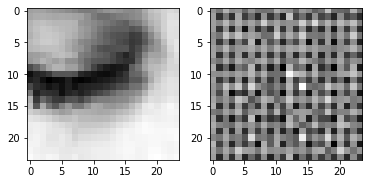

tensor([-0.1900, -0.1023, -0.0596,  0.0776,  0.0215,  0.1384,  0.0653, -0.0334,
         0.1816,  0.2260,  0.0843, -0.0292,  0.0327,  0.0212,  0.1244,  0.2018,
        -0.0524,  0.4753,  0.0203,  0.0068,  0.0966, -0.0760,  0.0833, -0.0881,
         0.3964,  0.0518,  0.1648, -0.0719,  0.1053, -0.0542,  0.1625, -0.1118,
         0.0940, -0.0840, -0.1142,  0.3300, -0.0027, -0.1608,  0.0897, -0.0307,
        -0.2970, -0.1083,  0.1844,  0.3362, -0.1557, -0.1282, -0.3007,  0.0725,
         0.0393,  0.2122], device='cuda:0', grad_fn=<SelectBackward>)
100 0.007656294386833906 32.5615348815918 0.009284371510148048


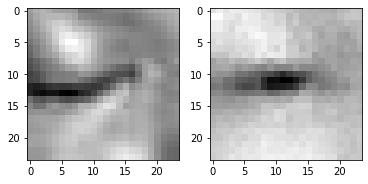

tensor([ 0.0198, -0.0672, -0.0825, -0.1676, -0.0681,  0.2746, -0.0836, -0.0366,
        -0.0874, -0.0141, -0.1181, -0.2258, -0.0374,  0.0534,  0.2130, -0.1792,
        -0.0066, -0.4856, -0.0036,  0.0033, -0.4774,  0.0743,  0.0475, -0.0141,
        -0.1136, -0.1077,  0.1173, -0.1646,  0.1181,  0.0044,  0.3305, -0.0579,
         0.1589,  0.0280, -0.1187, -0.1969, -0.0704, -0.1906,  0.0478, -0.0906,
         0.2371,  0.1086,  0.0175,  0.0721, -0.0990,  0.0998, -0.1701,  0.1747,
         0.0567, -0.1153], device='cuda:0', grad_fn=<SelectBackward>)
200 0.006462028715759516 28.50688934326172 0.007887372747063637


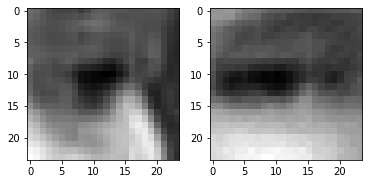

tensor([ 0.2111,  0.1173, -0.0055, -0.1416,  0.1407, -0.0376,  0.1558,  0.0535,
        -0.0096,  0.1502,  0.1891, -0.1818,  0.0363,  0.1794,  0.0450, -0.1570,
        -0.1873, -0.7252,  0.1156, -0.0056, -0.2025, -0.0261, -0.0359,  0.1036,
        -0.1534, -0.1847,  0.0143,  0.0683, -0.1648,  0.0846,  0.0569, -0.2826,
         0.1944, -0.0224,  0.0673, -0.0883, -0.0150,  0.3983,  0.1348,  0.0322,
         0.4821, -0.0450, -0.0658, -0.2329, -0.0849,  0.0045,  0.0305,  0.0822,
        -0.0675, -0.1464], device='cuda:0', grad_fn=<SelectBackward>)
300 0.007894313894212246 26.023799896240234 0.009195503778755665


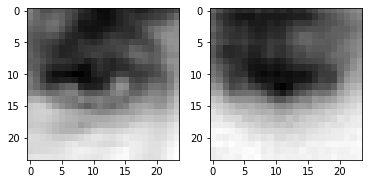

tensor([ 0.0852, -0.0289, -0.0528,  0.0566, -0.0113, -0.0532,  0.1503,  0.0862,
         0.0838,  0.0159,  0.0535, -0.0847, -0.0277,  0.0055, -0.1001, -0.1014,
         0.0535, -0.2120, -0.0415, -0.0036, -0.1931, -0.0781, -0.0168,  0.1034,
         0.0972,  0.0389,  0.0480,  0.0494,  0.0346,  0.0003,  0.0132, -0.1692,
         0.0712,  0.0434, -0.0717, -0.0739, -0.0123,  0.0780,  0.0026,  0.0814,
        -0.0252,  0.0240, -0.0618,  0.0735, -0.1565,  0.1328, -0.0618,  0.0105,
        -0.0320, -0.0157], device='cuda:0', grad_fn=<SelectBackward>)
400 0.0060494584031403065 19.556961059570312 0.007027306593954563


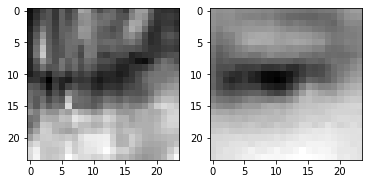

tensor([-0.0430, -0.0546, -0.0895, -0.2224,  0.0055,  0.4145,  0.0115, -0.0110,
        -0.0172,  0.0554,  0.0714, -0.6041, -0.0864,  0.1641,  0.0161, -0.0020,
        -0.1319,  0.3905,  0.1069, -0.0224,  0.7889,  0.0555,  0.1116,  0.1101,
         0.2403, -0.0235, -0.0806, -0.1608, -0.2955, -0.0509,  0.0262,  0.0624,
         0.0394, -0.0493, -0.1727,  0.0487,  0.1414,  0.5135, -0.0638, -0.2257,
         0.4639, -0.0763,  0.0375,  0.0235,  0.1288, -0.1355,  0.0548,  0.1241,
        -0.1344, -0.3037], device='cuda:0', grad_fn=<SelectBackward>)
500 0.004645142238587141 18.66304588317871 0.005578294396400452


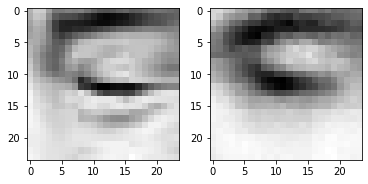

tensor([-0.1094, -0.0482, -0.0151, -0.0162, -0.0787, -0.1004, -0.0271, -0.1231,
         0.1485, -0.0805, -0.1140,  0.0577,  0.0263, -0.0222,  0.0358,  0.0294,
         0.1036, -0.1301, -0.0159,  0.0573, -0.2663, -0.0281, -0.0686,  0.0123,
         0.0792,  0.1250,  0.0471, -0.0339,  0.0493,  0.0165, -0.0681,  0.0288,
         0.1025, -0.0368, -0.1243,  0.0649, -0.1037,  0.0979,  0.1358, -0.0096,
        -0.1499,  0.1234, -0.0474, -0.1046, -0.0194,  0.0102,  0.0140, -0.0127,
        -0.0879,  0.0249], device='cuda:0', grad_fn=<SelectBackward>)
600 0.004292297642678022 15.523073196411133 0.005068451166152954


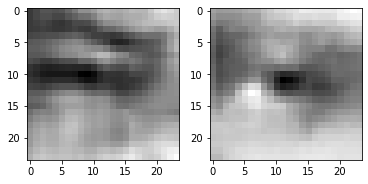

tensor([-0.0330, -0.1447, -0.0966, -0.0143, -0.0221,  0.0619,  0.0093,  0.0273,
        -0.0051, -0.0680, -0.0614, -0.0372, -0.0255, -0.0005, -0.0464, -0.1636,
         0.0039, -0.1672, -0.0381,  0.1073, -0.5071,  0.0739, -0.0108, -0.0920,
        -0.0413,  0.1169, -0.0262, -0.0834, -0.0036, -0.0315, -0.0411,  0.0027,
         0.0558, -0.0548, -0.0450, -0.0630,  0.0162, -0.2552, -0.0829,  0.0887,
        -0.3388,  0.0680, -0.0512, -0.4388, -0.1304,  0.0051, -0.0579, -0.0775,
         0.0544, -0.1178], device='cuda:0', grad_fn=<SelectBackward>)
700 0.003393105696886778 15.23204517364502 0.00415470777079463


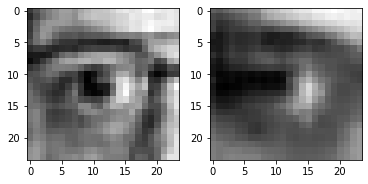

tensor([-0.0881,  0.0174, -0.0687,  0.0609, -0.0030, -0.1016,  0.0077,  0.0398,
         0.1103, -0.0498,  0.0811,  0.0832,  0.0463, -0.0141, -0.0908, -0.1011,
         0.1019,  0.5056, -0.1377, -0.0270,  0.2452, -0.0255,  0.0384, -0.0199,
         0.0084, -0.0529,  0.0870,  0.0399,  0.0782,  0.0179, -0.1876,  0.0633,
         0.0285, -0.0179, -0.0086,  0.0165,  0.0942, -0.1120,  0.0407,  0.0218,
        -0.0926,  0.0932,  0.0428,  0.0603, -0.1063, -0.0626, -0.0991, -0.0492,
        -0.0083,  0.0175], device='cuda:0', grad_fn=<SelectBackward>)
800 0.004315790720283985 14.805474281311035 0.005056064575910568


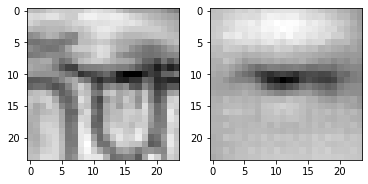

tensor([ 0.0013, -0.0390, -0.0229, -0.0551, -0.0847,  0.0081, -0.1284,  0.0164,
         0.0326, -0.0263,  0.0773, -0.0915,  0.0435, -0.0003,  0.0191,  0.0167,
         0.0882, -0.0880,  0.0387,  0.0507, -0.1065,  0.0052, -0.0005,  0.0603,
         0.1103, -0.0382,  0.0968, -0.0422,  0.0176, -0.0398, -0.0689,  0.0035,
         0.0889, -0.0042, -0.1242,  0.1423, -0.0126,  0.1741, -0.0094, -0.0221,
        -0.0729,  0.0559,  0.0301, -0.0202, -0.0378,  0.1128, -0.0255, -0.0218,
         0.0166,  0.0080], device='cuda:0', grad_fn=<SelectBackward>)
900 0.009160754270851612 13.936129570007324 0.009857560507953167


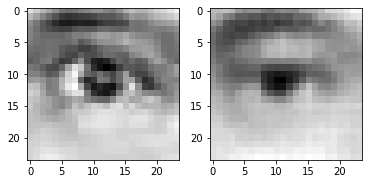

tensor([-0.1444, -0.0072,  0.0238,  0.1054, -0.0158,  0.0778, -0.0715, -0.0188,
         0.0151,  0.0535, -0.0626,  0.0090, -0.0263, -0.0660,  0.0547, -0.0658,
         0.0019,  0.4963, -0.2192, -0.0236,  0.5313,  0.0355,  0.0174,  0.0345,
        -0.0249,  0.0412, -0.0760, -0.0458, -0.0776, -0.0007, -0.1054, -0.1512,
        -0.0785,  0.0237, -0.0092,  0.0339, -0.0292, -0.0167, -0.0641,  0.0900,
         0.0965,  0.0621, -0.0585,  0.0187, -0.0855,  0.0986, -0.0356, -0.0026,
         0.0710,  0.0554], device='cuda:0', grad_fn=<SelectBackward>)
1000 0.004227334633469582 15.666704177856445 0.005010670050978661


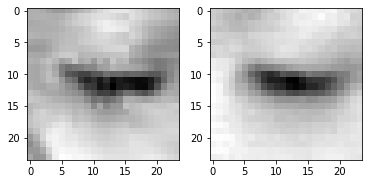

tensor([-0.1680,  0.0024, -0.0578,  0.2860, -0.2065, -0.2751,  0.0799, -0.0145,
        -0.1421, -0.1256,  0.0122,  0.3719,  0.0456, -0.0008, -0.0164, -0.0048,
         0.2409,  0.0070,  0.0663,  0.0069,  0.2961, -0.1022,  0.0104, -0.2553,
        -0.1390,  0.1776, -0.0283,  0.1773,  0.1149, -0.1419, -0.0222,  0.1368,
        -0.0645, -0.1057, -0.1165,  0.0609, -0.0134, -0.1412,  0.0654,  0.1603,
        -0.0043,  0.1599,  0.0056, -0.1022, -0.0126, -0.2783,  0.1728, -0.0270,
        -0.0626, -0.1238], device='cuda:0', grad_fn=<SelectBackward>)
1100 0.0037057825829833746 14.277474403381348 0.004419656470417976


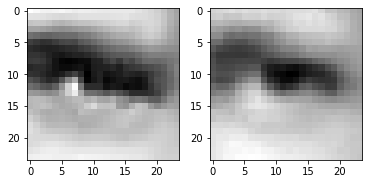

tensor([-0.0673, -0.0489,  0.0033, -0.0588, -0.0351,  0.0118,  0.0258, -0.0039,
         0.0390, -0.0567, -0.0750,  0.0442, -0.0117, -0.0685,  0.0255, -0.0359,
         0.1736, -0.0069, -0.0571,  0.0130, -0.2551,  0.0247, -0.1043,  0.0583,
         0.0051, -0.0387, -0.0262,  0.0305, -0.0128, -0.0119, -0.1017, -0.0714,
         0.0212, -0.0014, -0.0877, -0.0134, -0.0779,  0.2147, -0.0183,  0.0122,
         0.0958,  0.1324,  0.0014,  0.0896, -0.0375,  0.0315,  0.0124, -0.0375,
        -0.0177,  0.0239], device='cuda:0', grad_fn=<SelectBackward>)
1200 0.003678771434351802 12.790987968444824 0.004318320658057928


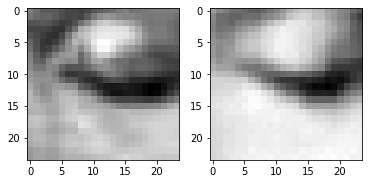

tensor([-0.0674, -0.0741,  0.0319, -0.1518, -0.0702,  0.0103, -0.1118, -0.0052,
        -0.0148,  0.0976,  0.0914, -0.0623,  0.0468, -0.0282, -0.0410, -0.1094,
        -0.0591, -0.1904,  0.0144,  0.0448, -0.1049, -0.0162, -0.0315,  0.0282,
        -0.1471, -0.0416,  0.0152, -0.0602,  0.0682,  0.0591,  0.0421,  0.0348,
         0.1402, -0.0382,  0.0176, -0.0821, -0.0749, -0.0615, -0.0111, -0.0671,
         0.3114, -0.0795, -0.0167, -0.0825,  0.0260,  0.0648, -0.0755, -0.0983,
         0.0020,  0.0686], device='cuda:0', grad_fn=<SelectBackward>)
1300 0.0033447782043367624 12.679832458496094 0.003978769760578871


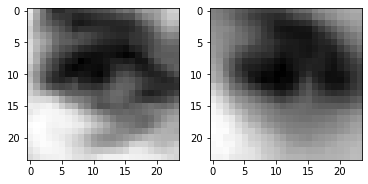

tensor([ 0.0665, -0.0818, -0.0121, -0.0547,  0.1753,  0.0421,  0.2870,  0.0641,
        -0.1903, -0.2245, -0.0659,  0.1997, -0.0128,  0.0237,  0.0537,  0.0976,
         0.1466, -0.1222, -0.1215, -0.1205,  0.4424,  0.0163,  0.0768,  0.1207,
         0.1266, -0.0956,  0.0585,  0.2136, -0.0581,  0.1344, -0.1030, -0.0896,
        -0.2069,  0.0278,  0.1214, -0.1102, -0.0778, -0.5564, -0.0425, -0.0410,
        -0.1215,  0.1941,  0.0398, -0.1566,  0.0451, -0.1423,  0.0025, -0.1060,
         0.1247, -0.1981], device='cuda:0', grad_fn=<SelectBackward>)
1400 0.003853799542412162 11.907990455627441 0.004449198953807354


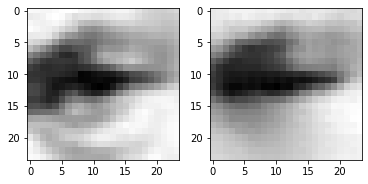

tensor([ 0.0998,  0.0653, -0.0321,  0.0332,  0.1289,  0.0524, -0.1619, -0.0327,
        -0.1179,  0.0205,  0.0864,  0.0238,  0.0124,  0.0614, -0.0006,  0.0341,
        -0.0097, -0.1827,  0.1165,  0.0227, -0.2639, -0.0264,  0.0083,  0.0401,
        -0.0504, -0.1910, -0.0079, -0.0215,  0.0870, -0.0266, -0.0035,  0.0239,
        -0.1347,  0.0420, -0.0805, -0.0093,  0.0480, -0.0744, -0.0337, -0.2389,
        -0.2036,  0.0034,  0.0524, -0.1655, -0.0270,  0.0847,  0.0250,  0.0633,
        -0.0094, -0.0306], device='cuda:0', grad_fn=<SelectBackward>)
1500 0.003268113126978278 12.12336540222168 0.003874281421303749


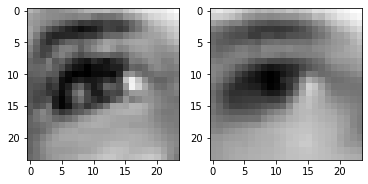

tensor([-2.3127e-01, -8.7150e-02, -1.5405e-01, -1.2214e-01, -1.2865e-02,
        -8.4549e-02, -3.7856e-01,  1.0397e-01, -1.6095e-01,  4.1877e-02,
         2.1491e-02,  3.6498e-02,  6.5730e-02,  6.9315e-02, -2.1939e-02,
        -1.3851e-01,  1.7574e-01, -4.4055e-02, -3.5707e-02,  3.6635e-03,
         1.6343e-04,  8.6350e-02, -9.3655e-02, -1.8076e-01,  9.9947e-02,
        -6.7868e-02,  3.9630e-02,  6.4925e-02,  2.1975e-01, -5.6593e-02,
         3.8733e-02,  7.0005e-02,  1.6228e-01, -2.6397e-02, -4.4071e-02,
        -1.7147e-01,  2.9183e-02, -3.5230e-01,  6.9019e-03, -6.3453e-02,
         2.2485e-01, -2.5022e-02, -1.0983e-01,  1.7907e-02,  3.4927e-02,
        -2.9474e-01,  7.7966e-02, -1.4004e-01,  2.7954e-03,  4.1308e-02],
       device='cuda:0', grad_fn=<SelectBackward>)
1600 0.0032964912243187428 12.045470237731934 0.0038987647276371717


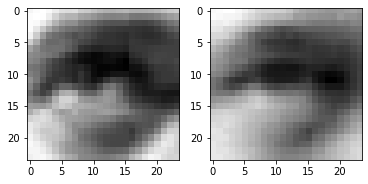

tensor([-0.0450, -0.0128, -0.0443,  0.0950, -0.0027,  0.1329,  0.1581, -0.0667,
        -0.1020,  0.0250, -0.0175, -0.1242, -0.1143, -0.0426, -0.0402,  0.0181,
        -0.0192,  0.3701, -0.0742,  0.0108,  0.5200,  0.0715, -0.0417,  0.0786,
        -0.1216, -0.0843, -0.0985,  0.1567, -0.0633, -0.0136, -0.0369, -0.0780,
        -0.0192,  0.0328,  0.0610, -0.1396,  0.0264, -0.0394,  0.0324,  0.0693,
        -0.0421, -0.0251, -0.0284,  0.1161, -0.1028, -0.0934,  0.0015,  0.0285,
        -0.0230,  0.0899], device='cuda:0', grad_fn=<SelectBackward>)
1700 0.003139390842989087 10.169398307800293 0.0036478606052696705


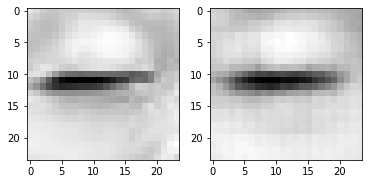

tensor([-0.0719, -0.0114,  0.0139, -0.0638, -0.0211, -0.0105,  0.1221, -0.0046,
         0.0570, -0.0491, -0.0410,  0.1833,  0.0004,  0.0044, -0.0482, -0.0391,
         0.0185,  0.0723, -0.1174,  0.0057,  0.0635, -0.0007,  0.0021,  0.0331,
        -0.0768, -0.0919, -0.0049,  0.0503, -0.0104,  0.0102, -0.0033,  0.0425,
         0.0031, -0.0597,  0.0142, -0.0354, -0.0430,  0.0485,  0.0103,  0.0243,
        -0.0184,  0.0073,  0.0072, -0.0094, -0.0064,  0.0200,  0.0310, -0.0351,
        -0.0064,  0.1580], device='cuda:0', grad_fn=<SelectBackward>)
1800 0.004171829205006361 10.823304176330566 0.004712994210422039


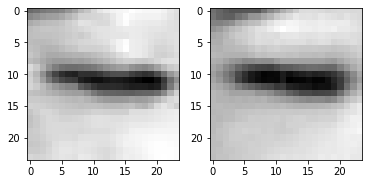

tensor([-0.0682,  0.0618,  0.0357, -0.0867, -0.0097,  0.1269,  0.0223, -0.0338,
        -0.1779,  0.0140,  0.0373, -0.2020, -0.0362, -0.0282, -0.0161,  0.0526,
        -0.1597, -0.0559,  0.0180, -0.0372,  0.0821, -0.0019,  0.1001,  0.0642,
         0.2123, -0.0687, -0.0353,  0.0716, -0.1482,  0.1208,  0.0327, -0.0793,
        -0.2196,  0.0132,  0.1245, -0.0941, -0.0565,  0.0273, -0.0650, -0.0372,
         0.0572, -0.1866,  0.0324, -0.0225,  0.0284, -0.1408,  0.0415,  0.0190,
        -0.0376, -0.0884], device='cuda:0', grad_fn=<SelectBackward>)
1900 0.0031623910181224346 11.015246391296387 0.003713153302669525


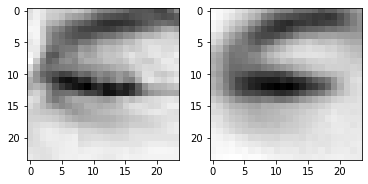

tensor([ 0.0496, -0.0070, -0.0243, -0.1479,  0.0021, -0.0470,  0.0430,  0.0206,
         0.0253,  0.0640,  0.1659,  0.0414,  0.0241, -0.0098,  0.0311, -0.0565,
         0.0414, -0.2301, -0.0206,  0.0097, -0.1713, -0.0007,  0.0086, -0.0034,
         0.0335, -0.0748,  0.0129,  0.0061,  0.0911, -0.0177,  0.1079,  0.0749,
         0.0735, -0.0493,  0.0733, -0.0515,  0.0249,  0.0355,  0.0281, -0.0735,
        -0.1032, -0.1115, -0.0158, -0.0253,  0.0510,  0.0216, -0.0709, -0.0016,
         0.0117,  0.0997], device='cuda:0', grad_fn=<SelectBackward>)
2000 0.0028977515175938606 10.053641319274902 0.003400433575734496


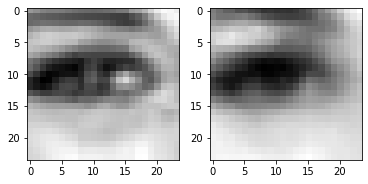

tensor([ 0.0990, -0.0026,  0.0327,  0.0629, -0.0650,  0.0117,  0.0614, -0.0379,
         0.0679,  0.0357, -0.0281, -0.0197, -0.0619, -0.0327,  0.0020, -0.0614,
        -0.0335, -0.2340,  0.0543, -0.0146, -0.1919, -0.0405, -0.0434,  0.0286,
        -0.0934, -0.0651, -0.0316, -0.0710, -0.0433,  0.0482, -0.0252, -0.0219,
         0.1034, -0.0004, -0.1148, -0.0422, -0.0532,  0.1067,  0.0282,  0.0265,
        -0.0218, -0.0478, -0.0620, -0.2037,  0.0050,  0.0260,  0.0707,  0.0200,
        -0.0459, -0.0819], device='cuda:0', grad_fn=<SelectBackward>)
2100 0.003374568186700344 10.477113723754883 0.0038984238635748625


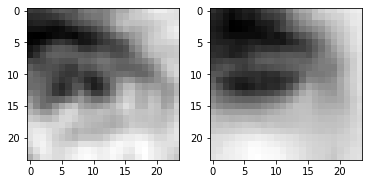

tensor([ 0.0274,  0.0342, -0.0277,  0.0008,  0.1175, -0.0547, -0.1751, -0.0687,
         0.0514,  0.0384, -0.0273, -0.0978,  0.0259, -0.0019,  0.0468,  0.0183,
        -0.1379,  0.0400, -0.0134,  0.0743,  0.1211, -0.0190, -0.0552,  0.0488,
         0.0498,  0.0880, -0.0213,  0.0537, -0.0327, -0.0350,  0.0276,  0.0063,
         0.0506,  0.0022, -0.0621, -0.0342, -0.0038,  0.1321, -0.0137, -0.1065,
        -0.0259, -0.0794,  0.0249, -0.0468, -0.0493,  0.0553, -0.0272, -0.0129,
         0.0291,  0.1199], device='cuda:0', grad_fn=<SelectBackward>)
2200 0.003089835634455085 10.337150573730469 0.003606693120673299


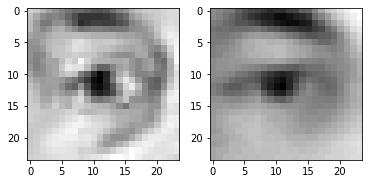

tensor([-0.0237,  0.0075, -0.0083, -0.1033,  0.0255,  0.0008, -0.0755,  0.0151,
        -0.0548, -0.0159,  0.0434,  0.0982, -0.1023, -0.0212, -0.0073, -0.0326,
         0.0646, -0.0758, -0.0279, -0.0109,  0.1676, -0.0490, -0.0306,  0.0187,
         0.0281,  0.0548, -0.0229,  0.0162,  0.0803, -0.0044,  0.0872,  0.0772,
         0.0382, -0.0013,  0.0409,  0.0804,  0.0141,  0.0090, -0.0091, -0.0851,
        -0.1463, -0.0827, -0.0686, -0.0690,  0.0803, -0.0175,  0.0085, -0.0029,
        -0.0463,  0.0855], device='cuda:0', grad_fn=<SelectBackward>)
2300 0.0031726923771202564 9.374667167663574 0.003641425631940365


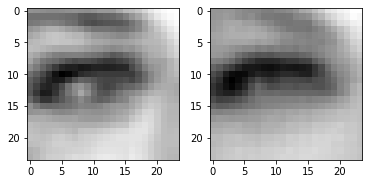

tensor([ 0.0977,  0.0825,  0.0395, -0.1667, -0.1023, -0.0323,  0.1790, -0.0339,
        -0.0238,  0.0277, -0.0466, -0.1650,  0.0304,  0.0155, -0.0031, -0.0484,
        -0.0522,  0.1204,  0.1547, -0.0443,  0.0177, -0.0738,  0.0846,  0.0302,
         0.0534,  0.0646,  0.0588,  0.0675, -0.0412,  0.0484,  0.1213,  0.0996,
        -0.1451, -0.0351,  0.0459,  0.0476, -0.0010,  0.1438, -0.0025, -0.0810,
        -0.2375, -0.0800,  0.0161,  0.0043,  0.0878,  0.1122,  0.0034,  0.0239,
        -0.0505, -0.1078], device='cuda:0', grad_fn=<SelectBackward>)
2400 0.0037076431326568127 9.513324737548828 0.004183309152722359


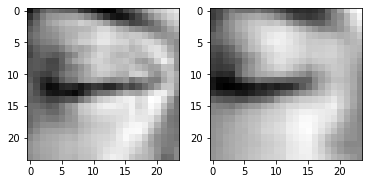

tensor([-0.1389,  0.0130, -0.0335,  0.0290, -0.0111, -0.0206,  0.0869, -0.0023,
        -0.0325,  0.0295, -0.0183,  0.0735, -0.0172,  0.0235, -0.0528, -0.0057,
         0.0376,  0.0263,  0.0413, -0.0473, -0.2297, -0.0273, -0.0074, -0.0282,
         0.0365,  0.0267, -0.0357,  0.0084, -0.0352,  0.0024, -0.0340,  0.0053,
        -0.0149, -0.0030, -0.0433,  0.0423,  0.0468,  0.0515, -0.0288, -0.0019,
        -0.0308,  0.0351, -0.0269,  0.0325,  0.0255, -0.0046,  0.0337,  0.0176,
        -0.0499, -0.0515], device='cuda:0', grad_fn=<SelectBackward>)
2500 0.003006743500009179 10.00872802734375 0.003507179906591773


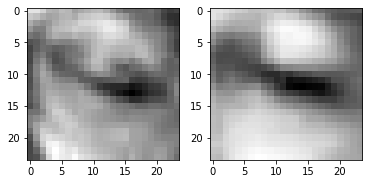

tensor([-0.1403,  0.0153,  0.0071, -0.0742,  0.0795,  0.0331, -0.0314,  0.0444,
         0.0525, -0.0366,  0.1800, -0.0187, -0.0323,  0.0559,  0.0389, -0.0320,
        -0.0348,  0.0857,  0.0404, -0.0528,  0.2767, -0.0180,  0.0422,  0.0487,
         0.1156,  0.1118,  0.0384, -0.1337,  0.0653,  0.0337,  0.0932,  0.0459,
        -0.0400, -0.0199,  0.0940,  0.0052,  0.0245, -0.1479,  0.0255, -0.1327,
        -0.1320,  0.0301, -0.0435, -0.0653,  0.0759,  0.1128, -0.0122,  0.0275,
        -0.0380, -0.2434], device='cuda:0', grad_fn=<SelectBackward>)
2600 0.0026011832524091005 9.570990562438965 0.0030797328799962997


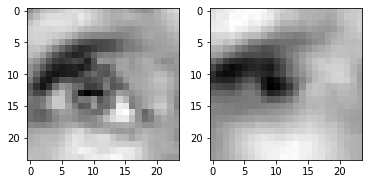

tensor([-0.1649,  0.0123, -0.0609,  0.1212,  0.1447,  0.0059, -0.1771, -0.0301,
         0.0432, -0.0096, -0.0099,  0.0993, -0.0342, -0.0469,  0.0023,  0.0834,
         0.1220, -0.2403, -0.0076, -0.0384,  0.0517, -0.0447, -0.0335, -0.0783,
         0.1639,  0.0343, -0.0288, -0.0663,  0.3263, -0.0290, -0.0343, -0.0248,
         0.0971, -0.0059,  0.2200,  0.1108,  0.0565, -0.0795, -0.0291,  0.1458,
        -0.0120, -0.0150, -0.0035,  0.0481,  0.0243, -0.0945, -0.0318,  0.0391,
        -0.0337,  0.2034], device='cuda:0', grad_fn=<SelectBackward>)
2700 0.0033149525988847017 9.20787525177002 0.003775346325710416


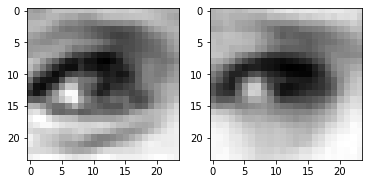

tensor([ 1.3241e-01,  1.8084e-02,  2.8238e-02, -4.4589e-02,  1.0983e-02,
         5.0554e-02,  3.6381e-02, -3.7738e-04,  1.7364e-02, -6.4569e-02,
         2.9204e-02, -1.8210e-02, -1.1620e-02,  3.4405e-03, -1.0077e-02,
         3.4717e-03, -6.3927e-02, -5.5913e-02, -2.5854e-01,  2.6116e-03,
        -3.5692e-01,  7.1587e-03,  6.0194e-03,  3.4457e-02,  1.3072e-01,
        -3.6652e-02,  2.3562e-02, -4.6726e-03, -1.3150e-01,  2.1621e-02,
         4.0930e-02, -1.8735e-02, -1.3186e-01, -3.9370e-03,  9.8652e-02,
        -7.1620e-02, -1.9719e-02,  4.0391e-02, -9.9981e-04, -1.5934e-02,
        -8.8149e-02,  4.2037e-02,  3.8773e-04,  8.0829e-02,  8.1681e-03,
         4.2449e-03,  2.8606e-04, -9.9421e-03,  1.8837e-02, -5.6768e-03],
       device='cuda:0', grad_fn=<SelectBackward>)
2800 0.0021058712154626846 8.90852165222168 0.002551297191530466


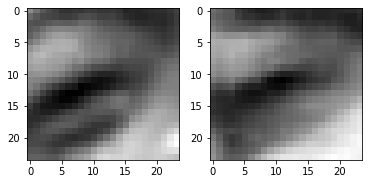

tensor([ 1.2538e-02,  7.2956e-03, -3.3752e-02,  6.5534e-02,  8.3805e-02,
        -6.5573e-03,  2.8987e-02, -2.1376e-02,  3.8453e-02,  4.6609e-03,
        -3.8550e-02,  1.0634e-01, -3.0378e-02, -2.8187e-02, -4.2617e-02,
         1.8123e-02,  1.2226e-02, -3.8861e-02, -1.5554e-01,  6.1871e-02,
        -4.0043e-02, -2.2792e-02, -1.6130e-02, -7.0037e-02,  2.0151e-01,
        -4.4398e-02,  1.7773e-03, -7.5472e-02, -7.8565e-02, -2.0914e-04,
        -6.4550e-02, -6.5545e-02,  1.5054e-02,  5.6424e-03, -5.1503e-02,
        -2.4749e-02, -1.4039e-03, -2.4433e-01, -4.0460e-02,  6.6171e-02,
         1.0137e-01,  1.0701e-02, -3.3717e-03, -1.2892e-03, -5.8000e-02,
        -8.0813e-02,  1.0122e-02,  1.7790e-02, -1.6344e-03,  1.4232e-01],
       device='cuda:0', grad_fn=<SelectBackward>)
2900 0.002826874377205968 10.050137519836426 0.0033293813467025757


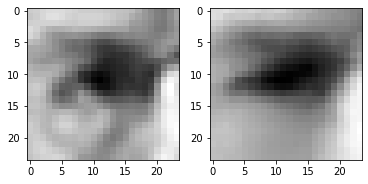

tensor([-0.0181, -0.0030, -0.0070, -0.0089,  0.0579,  0.0696, -0.0342,  0.0074,
         0.0591, -0.0590, -0.0023,  0.0914, -0.0151, -0.0011,  0.0110,  0.0144,
         0.0537, -0.0624,  0.1040, -0.0149,  0.0640,  0.0212, -0.0018,  0.0429,
        -0.1453, -0.1015,  0.0111, -0.0848, -0.0010,  0.0150,  0.0115,  0.0003,
         0.0108, -0.0068,  0.0027, -0.0986, -0.0025, -0.2542,  0.0699, -0.0486,
         0.0273,  0.1300, -0.0035,  0.0211,  0.0039,  0.0071, -0.0097,  0.0020,
        -0.0254,  0.0090], device='cuda:0', grad_fn=<SelectBackward>)
3000 0.0033375429920852184 9.556295394897461 0.003815357806161046


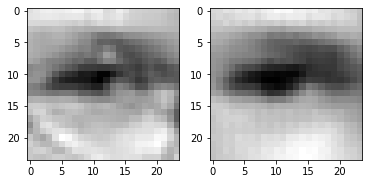

tensor([ 0.0312, -0.0657,  0.0555,  0.0441,  0.0270,  0.0439, -0.1077, -0.0364,
        -0.0497,  0.1806,  0.0176, -0.0830, -0.0231, -0.0250, -0.0836, -0.0092,
        -0.0082,  0.2899,  0.2495,  0.0254, -0.4453,  0.0305,  0.0030, -0.0882,
        -0.0361,  0.0545, -0.0463, -0.2108,  0.0374, -0.0391,  0.0226,  0.0344,
         0.1193, -0.0556, -0.1331,  0.0487, -0.0019, -0.0500,  0.0136, -0.1637,
         0.1686, -0.2034,  0.0022,  0.2881,  0.0242,  0.0068,  0.0356,  0.0325,
         0.0016, -0.0352], device='cuda:0', grad_fn=<SelectBackward>)
3100 0.0022967366967350245 9.311087608337402 0.0027622911147773266


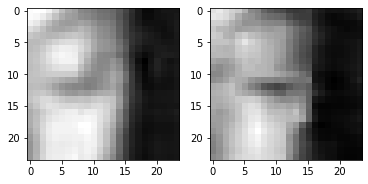

tensor([ 0.0687,  0.0484,  0.0157,  0.1124, -0.0304, -0.0301,  0.1062, -0.0254,
         0.1007, -0.0467,  0.0952, -0.0807,  0.0419,  0.0244,  0.0190, -0.0256,
        -0.0201, -0.0550, -0.0894,  0.0013,  0.2081, -0.0415, -0.0062, -0.0568,
         0.0852, -0.0144,  0.0590, -0.0818, -0.0429,  0.0164, -0.0406, -0.0021,
        -0.1765,  0.0288, -0.0199,  0.0658, -0.0150, -0.1729,  0.0237,  0.0890,
        -0.2714, -0.0625,  0.0689,  0.2949, -0.0122,  0.0740, -0.0043, -0.0242,
        -0.0149, -0.0386], device='cuda:0', grad_fn=<SelectBackward>)
3200 0.003252375638112426 8.8974609375 0.0036972486414015293


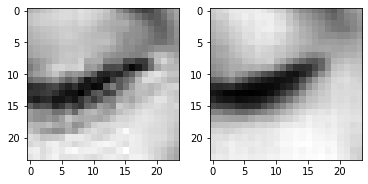

tensor([-0.0545, -0.0175,  0.0184,  0.0066,  0.0684, -0.0004, -0.0282, -0.0383,
         0.0182,  0.0417, -0.0598, -0.0464,  0.0122, -0.0363,  0.0105, -0.0196,
        -0.0056, -0.0653, -0.0471, -0.0113,  0.0019,  0.0504,  0.0064, -0.0199,
        -0.0832,  0.0235,  0.0060, -0.0534,  0.0152,  0.0208, -0.0121, -0.0250,
         0.0597, -0.0126,  0.0710, -0.0164, -0.0077, -0.2217,  0.0261, -0.0277,
        -0.0617,  0.0085,  0.0150,  0.0398, -0.0078, -0.0304, -0.0266,  0.0034,
         0.0093,  0.0358], device='cuda:0', grad_fn=<SelectBackward>)
3300 0.0027481087017804384 8.735052108764648 0.003184861270710826


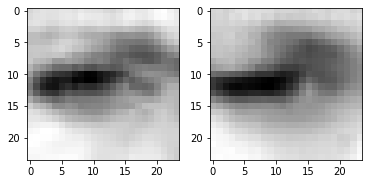

tensor([ 0.0435, -0.0254,  0.0283,  0.0495,  0.0305,  0.0047, -0.0540,  0.0023,
        -0.0112,  0.0880,  0.0120,  0.0707,  0.0037,  0.0193, -0.0214, -0.0061,
         0.0264,  0.1027,  0.0148, -0.0139,  0.2493,  0.0277,  0.0358, -0.0665,
        -0.0549,  0.0617, -0.0235, -0.0336,  0.0514, -0.0061,  0.0623,  0.0108,
         0.0204,  0.0134,  0.0337, -0.0640,  0.0229, -0.0990, -0.0008, -0.0459,
        -0.0100,  0.0229, -0.0285, -0.0654,  0.0437, -0.0223,  0.0299,  0.0354,
         0.0037, -0.0419], device='cuda:0', grad_fn=<SelectBackward>)
3400 0.0025774717796593904 8.290818214416504 0.002992012770846486


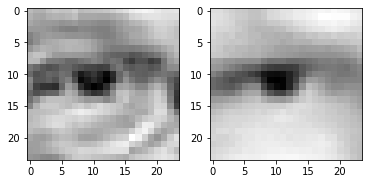

tensor([ 1.5260e-02,  4.3392e-03,  1.2580e-02, -1.0427e-01, -3.9902e-02,
         1.3022e-02, -1.9589e-03,  1.5857e-02, -2.7353e-02,  4.9136e-02,
         2.2164e-02,  1.6803e-01, -1.0422e-02,  1.8678e-02, -1.6802e-02,
         4.4428e-03,  2.7551e-01,  2.2829e-02, -1.1535e-01,  2.2286e-02,
         8.1403e-02,  6.3363e-03,  2.5490e-02, -4.9048e-02, -7.4046e-02,
        -1.3933e-01,  2.7794e-03, -4.1829e-02,  4.8377e-02, -2.7563e-02,
         4.5516e-02,  7.0201e-02, -2.3088e-02, -3.5332e-03,  2.3137e-04,
        -7.7059e-02,  1.5951e-02, -7.3754e-02, -2.0051e-02, -6.3302e-02,
         5.1564e-02,  2.0322e-01,  9.4399e-03,  2.8102e-02,  2.5260e-02,
         3.4614e-03,  3.8066e-02, -1.0920e-02, -5.0530e-03, -1.9081e-01],
       device='cuda:0', grad_fn=<SelectBackward>)
3500 0.0037887031212449074 8.666579246520996 0.004222032148391008


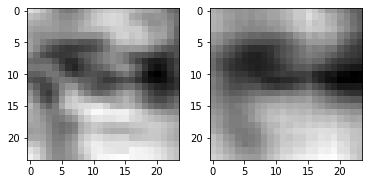

tensor([-0.0894,  0.0295,  0.0243, -0.0779, -0.0189,  0.0131, -0.0300, -0.0534,
         0.0553, -0.0224,  0.0692, -0.0065,  0.0248, -0.0377,  0.0233,  0.0010,
        -0.1537,  0.0937, -0.1783,  0.0294,  0.4022,  0.0127, -0.0374,  0.0357,
        -0.1055, -0.0888,  0.0232, -0.0969, -0.0659,  0.0623, -0.0481, -0.0933,
        -0.0622,  0.0295,  0.0510, -0.1000, -0.0541, -0.0479,  0.0076,  0.0260,
         0.2318, -0.1112,  0.0181, -0.2012, -0.0465,  0.0638, -0.0465, -0.0420,
         0.0256,  0.0527], device='cuda:0', grad_fn=<SelectBackward>)
3600 0.0027121086604893208 8.733009338378906 0.003148759016767144


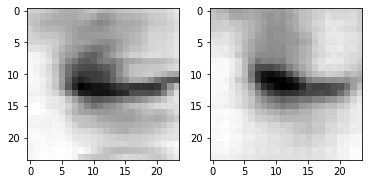

tensor([ 0.0167, -0.0327, -0.0077, -0.0141,  0.1144,  0.0485, -0.0837, -0.0250,
        -0.0201, -0.0221, -0.0579,  0.0804,  0.0020, -0.0672, -0.0035,  0.0002,
        -0.0590, -0.0008, -0.0363, -0.0227, -0.0645,  0.0318, -0.0362,  0.0041,
         0.0527, -0.0296,  0.0067, -0.0394,  0.0069,  0.0187, -0.0193, -0.0438,
        -0.0818,  0.0325,  0.1302, -0.0300, -0.0080,  0.0603, -0.0202, -0.0331,
        -0.0234,  0.0382,  0.0107,  0.0067, -0.0266, -0.0572, -0.0061,  0.0215,
        -0.0042, -0.0871], device='cuda:0', grad_fn=<SelectBackward>)
3700 0.0026238784193992615 8.702040672302246 0.0030589804518967867


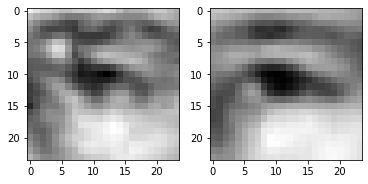

tensor([-4.4754e-02, -8.7603e-04, -3.1458e-02, -1.4974e-02,  5.7955e-02,
        -2.1919e-02, -1.8069e-04, -2.6476e-03,  1.7540e-02, -6.6643e-02,
         2.3504e-01, -7.9021e-02,  3.5639e-02, -2.3563e-02,  3.4905e-02,
        -3.4083e-02, -3.6619e-03,  2.4849e-02, -1.5970e-02,  1.7485e-03,
         2.4306e-01,  8.2841e-03,  6.7628e-03,  3.3779e-02,  2.4425e-02,
         1.0376e-01, -3.1991e-03,  1.1351e-01,  1.8636e-01, -1.8988e-02,
         5.8616e-02,  2.9014e-02,  1.6497e-01, -3.2702e-02,  1.8798e-02,
         8.1464e-03,  8.7393e-02,  2.5052e-02,  6.3756e-03, -1.3398e-01,
         3.9702e-02, -1.6681e-01,  2.4576e-02,  1.0921e-01,  5.3523e-02,
        -2.5486e-02, -6.7420e-03, -3.9146e-02, -1.8899e-02, -1.2690e-01],
       device='cuda:0', grad_fn=<SelectBackward>)
3800 0.0025266383308917284 9.198630332946777 0.0029865698888897896


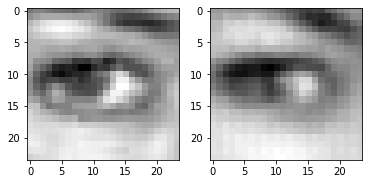

tensor([ 3.4676e-02, -4.1365e-03,  1.0847e-02,  6.6781e-02, -8.6536e-03,
        -6.1054e-03, -3.8599e-03, -1.4747e-03,  2.0563e-02,  2.9057e-02,
        -5.2058e-02, -3.7930e-02,  3.9819e-03,  2.3460e-02,  3.3924e-03,
        -3.7335e-02, -1.4919e-02,  4.1560e-02,  1.6485e-02, -1.5412e-02,
        -2.7455e-01, -5.1504e-04, -7.1653e-05, -4.3902e-02,  1.9704e-02,
         2.8135e-02,  6.7260e-03, -9.1406e-02, -8.1382e-02,  1.0907e-02,
         2.7642e-02,  6.3052e-03, -3.3373e-02, -1.9925e-03,  9.1986e-03,
        -1.8274e-02,  1.6743e-02, -1.2446e-02,  1.8355e-02,  8.9234e-03,
        -1.4386e-01, -1.9384e-03, -6.9498e-04,  3.6325e-03,  2.0723e-02,
         2.2440e-03, -4.5167e-03, -3.6083e-03, -6.5967e-03,  1.0865e-02],
       device='cuda:0', grad_fn=<SelectBackward>)
3900 0.0023775389418005943 8.538985252380371 0.0028044881764799356


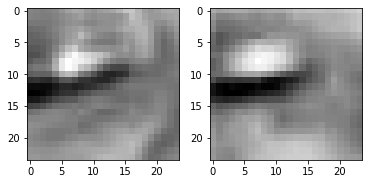

tensor([ 0.0727,  0.0034, -0.0051, -0.0102,  0.0215,  0.0436, -0.0371,  0.0016,
        -0.0292, -0.0310, -0.0276, -0.0096,  0.0129, -0.0146, -0.0073,  0.0049,
        -0.0282, -0.0391,  0.0695,  0.0095, -0.3437,  0.0069, -0.0013,  0.0369,
         0.0181,  0.0331, -0.0071,  0.0060, -0.0023, -0.0063,  0.0096, -0.0118,
        -0.0042,  0.0108,  0.0164,  0.0039,  0.0390, -0.0838, -0.0137, -0.0240,
        -0.1057,  0.0210,  0.0049,  0.0762,  0.0127, -0.0069,  0.0032, -0.0112,
        -0.0079, -0.0259], device='cuda:0', grad_fn=<SelectBackward>)
4000 0.0020619183778762817 8.270989418029785 0.0024754677433520555


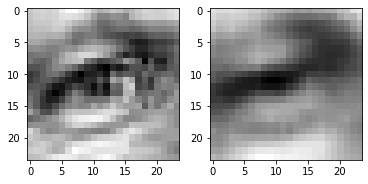

tensor([-0.0199, -0.0317,  0.0208,  0.0886,  0.0446, -0.0345, -0.0165, -0.0107,
         0.0237,  0.0904,  0.0601,  0.1596,  0.0148,  0.0189,  0.0113,  0.0103,
        -0.0319, -0.0368, -0.0207, -0.0055, -0.0906,  0.0083,  0.0281, -0.0387,
        -0.0162,  0.0032, -0.0091,  0.0661,  0.0111,  0.0025,  0.0274,  0.0540,
        -0.0870, -0.0652, -0.0367, -0.0214,  0.0274, -0.0214,  0.0225, -0.1690,
         0.0340,  0.0194,  0.0177,  0.1390,  0.0262,  0.0321,  0.0049, -0.0054,
         0.0069,  0.0358], device='cuda:0', grad_fn=<SelectBackward>)
4100 0.0029928558506071568 8.138254165649414 0.0033997686114162207


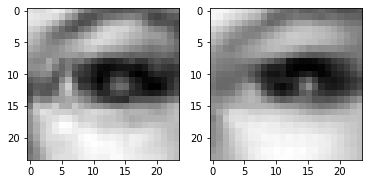

tensor([ 0.1026, -0.0071, -0.0151,  0.0608,  0.0239, -0.0167,  0.0993,  0.0126,
        -0.0254,  0.0141,  0.0035, -0.0197, -0.0118, -0.0011,  0.0431,  0.0085,
         0.0310, -0.1757,  0.1172, -0.0236, -0.3823,  0.0035,  0.0046,  0.0149,
        -0.0174,  0.0367,  0.0197, -0.1030,  0.0071,  0.0248,  0.0248,  0.0131,
         0.0911,  0.0149,  0.0328,  0.0468, -0.0134,  0.1702,  0.0107,  0.0012,
        -0.1000, -0.0549,  0.0081, -0.0384,  0.0058,  0.0067, -0.0020,  0.0054,
        -0.0194, -0.1028], device='cuda:0', grad_fn=<SelectBackward>)
4200 0.002571090357378125 8.224169731140137 0.002982298843562603


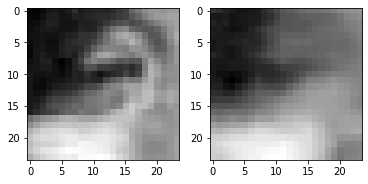

tensor([-0.0463, -0.0010,  0.0261, -0.0631,  0.0203,  0.0139, -0.0190, -0.0037,
         0.0250,  0.0132, -0.0325, -0.0284, -0.0013,  0.0133,  0.0084,  0.0109,
         0.0478,  0.1469, -0.0103, -0.0163, -0.0023,  0.0124,  0.0045, -0.0222,
         0.0737,  0.0208,  0.0011, -0.0471,  0.0039, -0.0036,  0.0131,  0.0632,
         0.0591, -0.0334, -0.0158, -0.0250,  0.0209,  0.1082,  0.0137, -0.1009,
         0.0066, -0.0293,  0.0193, -0.0073,  0.0012,  0.0144, -0.0078, -0.0080,
         0.0227, -0.0212], device='cuda:0', grad_fn=<SelectBackward>)
4300 0.002399160759523511 8.021090507507324 0.0028002152685076


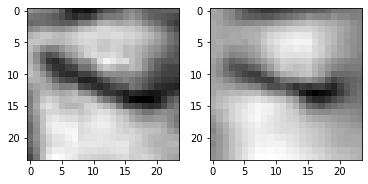

tensor([ 0.0379,  0.0110, -0.0109, -0.0073, -0.0054,  0.0203, -0.0300,  0.0071,
         0.0039, -0.0770, -0.0186, -0.0260, -0.0140, -0.0141,  0.0130,  0.0198,
         0.0046, -0.1175, -0.0677,  0.0202, -0.3798,  0.0115, -0.0283,  0.0490,
         0.0389,  0.0566, -0.0012,  0.1018, -0.0036, -0.0118,  0.0255,  0.0198,
         0.0584,  0.0064, -0.0548,  0.0289,  0.0241,  0.0260, -0.0109, -0.0678,
        -0.0161, -0.0495,  0.0093,  0.0328,  0.0152, -0.0255, -0.0055, -0.0083,
         0.0099, -0.0084], device='cuda:0', grad_fn=<SelectBackward>)
4400 0.006110841408371925 8.585065841674805 0.006540094502270222


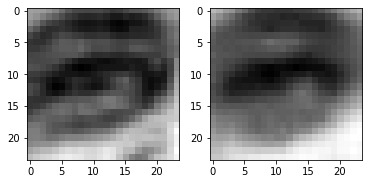

tensor([ 0.2067,  0.0198,  0.0389,  0.0560,  0.1091,  0.0914, -0.0164, -0.0206,
         0.0977, -0.0907,  0.1406,  0.0421, -0.0379, -0.0134, -0.0469,  0.0343,
        -0.0092, -0.1110, -0.0147,  0.0124,  0.0649, -0.0106,  0.0008, -0.0234,
         0.2118,  0.0859, -0.0167, -0.0849,  0.0260, -0.0096, -0.1288, -0.0127,
         0.1047,  0.0376, -0.2405,  0.1251, -0.0657, -0.0167, -0.0079,  0.0550,
         0.3889,  0.1313,  0.0176, -0.1216, -0.0277, -0.0687,  0.0153,  0.0220,
        -0.0062,  0.1716], device='cuda:0', grad_fn=<SelectBackward>)
4500 0.0024639961775392294 8.191705703735352 0.0028735813684761524


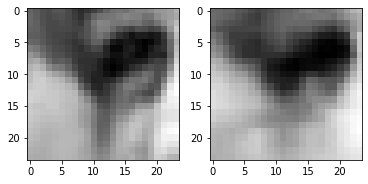

tensor([ 0.1311,  0.0095,  0.0543,  0.0387, -0.1652, -0.0099,  0.0155, -0.0382,
         0.0476, -0.0655, -0.0615, -0.0081, -0.0360,  0.0190, -0.0141, -0.0276,
         0.1230, -0.0450, -0.0299,  0.0128, -0.4389,  0.0081,  0.0072,  0.0005,
         0.1270,  0.1522,  0.0025,  0.0486,  0.0308,  0.0199,  0.1174,  0.0531,
         0.0356,  0.0472,  0.1119,  0.0782,  0.0176,  0.0807, -0.0202,  0.1238,
         0.0554,  0.0612, -0.0166,  0.0382,  0.0439,  0.0155,  0.0016,  0.0409,
        -0.0381, -0.0054], device='cuda:0', grad_fn=<SelectBackward>)
4600 0.002733505330979824 8.388144493103027 0.0031529124826192856


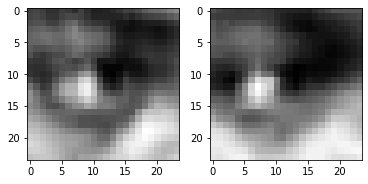

tensor([ 0.0494,  0.0075,  0.0046, -0.0576,  0.0042,  0.0315,  0.0543,  0.0139,
         0.0107, -0.0149, -0.0278, -0.0333,  0.0018, -0.0117,  0.0123,  0.0154,
         0.0169,  0.1336, -0.0161, -0.0039, -0.0440,  0.0110,  0.0083, -0.0256,
         0.1216, -0.0710, -0.0027,  0.0007, -0.0676,  0.0004, -0.0075, -0.0035,
        -0.0423, -0.0133,  0.0646, -0.0481,  0.0094,  0.0545,  0.0166,  0.0585,
         0.0130,  0.0115,  0.0340,  0.0526, -0.0096, -0.0377, -0.0017, -0.0143,
         0.0196, -0.0106], device='cuda:0', grad_fn=<SelectBackward>)
4700 0.00230240635573864 7.582871913909912 0.002681549871340394


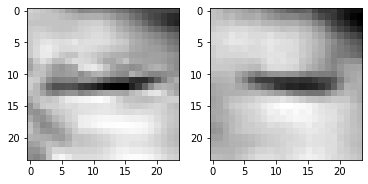

tensor([ 0.1391,  0.0327,  0.0408, -0.1186, -0.1299, -0.0300, -0.0191, -0.0097,
        -0.0468,  0.0581, -0.0565, -0.1382,  0.0040,  0.0083,  0.0072,  0.0105,
         0.0299, -0.0905, -0.0537,  0.0137, -0.1969, -0.0063,  0.0079,  0.0435,
        -0.0964,  0.0962,  0.0256, -0.0015, -0.0422, -0.0015,  0.0770,  0.0461,
         0.0102,  0.0149,  0.0937,  0.1187, -0.0295,  0.0448, -0.0241, -0.0344,
        -0.0370, -0.0701, -0.0280, -0.0503,  0.0075,  0.1305, -0.0024,  0.0150,
         0.0157,  0.0329], device='cuda:0', grad_fn=<SelectBackward>)
4800 0.00237546069547534 7.864538669586182 0.0027686876710504293


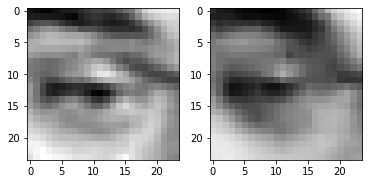

tensor([ 0.0739, -0.0032, -0.0180, -0.0189,  0.0479, -0.0215,  0.1463, -0.0145,
        -0.0416,  0.0205,  0.1088,  0.0196, -0.0031, -0.0131,  0.0138,  0.0081,
         0.0296,  0.0562,  0.0421,  0.0036,  0.1434, -0.0086, -0.0144, -0.0041,
        -0.0073, -0.0159,  0.0107,  0.0355,  0.0375, -0.0007, -0.0416, -0.0291,
         0.0225,  0.0003, -0.1012,  0.0425, -0.0395, -0.0097, -0.0049,  0.0239,
         0.0644,  0.0273, -0.0182, -0.0253,  0.0012, -0.0602, -0.0150,  0.0176,
        -0.0217, -0.0240], device='cuda:0', grad_fn=<SelectBackward>)
4900 0.002246835734695196 7.571649551391602 0.0026254181284457445


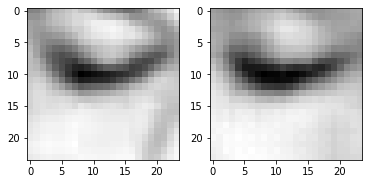

tensor([-8.4277e-02,  2.6561e-02, -6.3528e-03, -1.1964e-02,  8.0490e-02,
         1.7993e-02, -2.9520e-02, -3.7503e-02, -5.2533e-02,  4.8901e-04,
         3.7315e-02,  1.0393e-01,  9.0485e-03,  2.6840e-02,  1.7176e-02,
         2.7970e-02, -7.5585e-02, -4.7270e-02, -1.1391e-01,  2.3769e-02,
        -9.6055e-02,  5.3584e-02,  2.3494e-02,  4.0039e-02,  3.8818e-02,
        -1.9253e-02, -3.0783e-03,  8.4185e-02,  1.8683e-02, -4.1008e-02,
        -5.7734e-02, -6.4471e-03, -1.4313e-02, -5.2932e-03,  4.3634e-02,
        -4.8958e-02, -1.6022e-05, -1.6835e-01,  4.4864e-02, -4.2036e-02,
        -1.5465e-01,  2.5798e-02, -9.0613e-03, -4.7589e-02, -3.0543e-02,
        -4.9698e-02, -2.0972e-02, -2.9341e-02,  3.1758e-02,  7.6191e-03],
       device='cuda:0', grad_fn=<SelectBackward>)
5000 0.0025392647366970778 8.365251541137695 0.002957527292892337


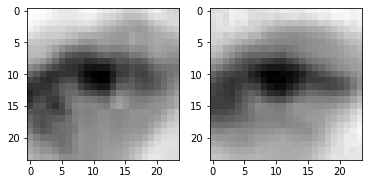

tensor([ 0.1686, -0.0316, -0.0019, -0.0642, -0.1011,  0.0309, -0.1205, -0.0140,
        -0.0561, -0.0400,  0.0015, -0.0378,  0.0359,  0.0159, -0.0259,  0.0174,
         0.0181, -0.1866,  0.0704,  0.0461, -0.1521, -0.0119, -0.0004,  0.1010,
         0.0484,  0.1309, -0.0160, -0.1915, -0.0404,  0.0105,  0.0430, -0.0453,
         0.0966, -0.0077,  0.2589,  0.0062, -0.0103,  0.1703, -0.0205,  0.1631,
        -0.1399,  0.1728, -0.0200,  0.0446,  0.0039,  0.0561,  0.0354, -0.0442,
         0.0188,  0.0778], device='cuda:0', grad_fn=<SelectBackward>)
5100 0.002620490500703454 8.263887405395508 0.0030336847994476557


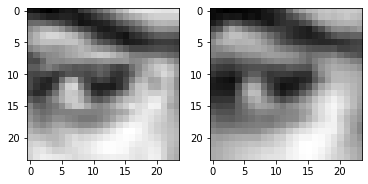

tensor([ 0.0542,  0.0248,  0.0088, -0.1142,  0.0140, -0.0252,  0.1080, -0.0026,
        -0.0311,  0.0476,  0.0264,  0.0534,  0.0062,  0.0120,  0.0231,  0.0071,
        -0.0364, -0.0153,  0.0635,  0.0217, -0.0991, -0.0025,  0.0003, -0.0220,
        -0.0337, -0.0471, -0.0030,  0.0418, -0.0146, -0.0197, -0.0448, -0.0322,
        -0.0531,  0.0012, -0.0575,  0.0735, -0.0190,  0.0573,  0.0033,  0.0186,
        -0.0234,  0.0436,  0.0126, -0.1073, -0.0258,  0.0249,  0.0023, -0.0166,
         0.0142, -0.0341], device='cuda:0', grad_fn=<SelectBackward>)
5200 0.0018130586249753833 7.5867486000061035 0.0021923959720879793


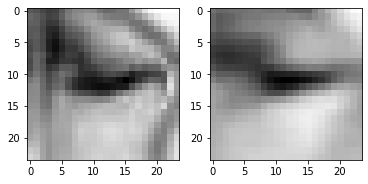

tensor([ 0.0821, -0.0242, -0.0291,  0.0286, -0.0097, -0.0091, -0.0612,  0.0112,
         0.0356, -0.0577, -0.0094,  0.0775, -0.0089, -0.0042, -0.0157, -0.0165,
        -0.0205,  0.0112, -0.0231, -0.0258,  0.2328,  0.0039, -0.0018,  0.0079,
         0.0602,  0.0096, -0.0091, -0.0016, -0.0541,  0.0153,  0.0054, -0.0327,
        -0.0037,  0.0158,  0.0191,  0.0147, -0.0034,  0.0475,  0.0021,  0.0666,
         0.2086,  0.0375, -0.0122,  0.0499,  0.0324, -0.0039, -0.0015,  0.0295,
        -0.0291, -0.1025], device='cuda:0', grad_fn=<SelectBackward>)
5300 0.0024417086970061064 7.693910121917725 0.0028264042921364307


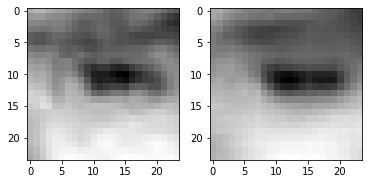

tensor([ 0.0182, -0.0092,  0.0034, -0.0010,  0.0991, -0.0162, -0.0611, -0.0125,
         0.0195, -0.0551,  0.0689, -0.0813,  0.0127, -0.0148,  0.0079,  0.0028,
         0.0019, -0.0990, -0.0794,  0.0364, -0.0781,  0.0046, -0.0004,  0.0031,
        -0.0433, -0.0808, -0.0185,  0.0068,  0.0241, -0.0065, -0.0384,  0.0350,
         0.1024, -0.0293,  0.0006,  0.0091, -0.0213,  0.1213,  0.0341, -0.1081,
        -0.1601, -0.0751,  0.0142, -0.0436, -0.0374, -0.1207,  0.0202, -0.0333,
        -0.0158,  0.0617], device='cuda:0', grad_fn=<SelectBackward>)
5400 0.0028958902694284916 7.761649131774902 0.003283972619101405


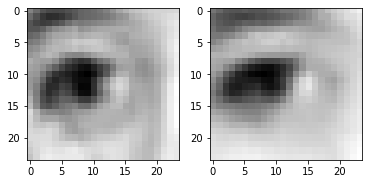

tensor([ 0.0298, -0.0370,  0.0110, -0.0346,  0.0181,  0.0057,  0.0973, -0.0074,
         0.0085,  0.0202, -0.0214,  0.0399,  0.0095,  0.0007,  0.0155, -0.0020,
        -0.0183,  0.0124, -0.0341, -0.0179,  0.1797, -0.0124,  0.0088, -0.0148,
         0.0284, -0.0063, -0.0180,  0.0037,  0.0327,  0.0148,  0.0062, -0.0057,
        -0.0495,  0.0012,  0.0224,  0.0387,  0.0180,  0.0970,  0.0253, -0.0617,
         0.0368, -0.0270,  0.0178,  0.0053,  0.0226,  0.0299, -0.0232,  0.0242,
        -0.0245, -0.0357], device='cuda:0', grad_fn=<SelectBackward>)
5500 0.002202447969466448 7.480279445648193 0.0025764619931578636


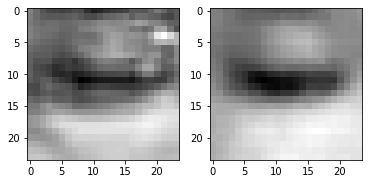

tensor([ 0.1454, -0.0168,  0.0124,  0.0312, -0.0945,  0.0936, -0.1087,  0.0604,
        -0.0182, -0.0666, -0.2377,  0.0925,  0.0403,  0.0185,  0.0374,  0.0149,
        -0.0303, -0.2912,  0.0911, -0.0446, -0.2501,  0.0732,  0.0239,  0.0465,
         0.0253, -0.0816, -0.0450,  0.0194, -0.1445, -0.0188,  0.0178,  0.0298,
        -0.0444, -0.0267,  0.0912,  0.1231,  0.0690, -0.1690,  0.0435,  0.0928,
         0.1223, -0.0177,  0.0697,  0.2313,  0.0303,  0.0731, -0.0686,  0.0366,
         0.0126, -0.1013], device='cuda:0', grad_fn=<SelectBackward>)
5600 0.0030094024259597063 8.004433631896973 0.0034096240997314453


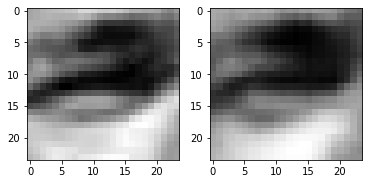

tensor([ 0.0555, -0.0016,  0.0185,  0.0220, -0.0305, -0.0223, -0.1393, -0.0261,
         0.0282, -0.0161, -0.0035, -0.1157, -0.0021,  0.0068,  0.0007,  0.0010,
         0.0443,  0.0004,  0.0609, -0.0070, -0.0941, -0.0188, -0.0143, -0.0165,
        -0.0487,  0.0762, -0.0142,  0.0383, -0.0228, -0.0072,  0.0190, -0.0006,
        -0.0267, -0.0052, -0.1175,  0.0398, -0.0099,  0.0705, -0.0068,  0.0277,
        -0.0231,  0.0214, -0.0164,  0.0268,  0.0031,  0.0048, -0.0115,  0.0047,
         0.0051, -0.0111], device='cuda:0', grad_fn=<SelectBackward>)
5700 0.0024149983655661345 7.4951171875 0.0027897541876882315


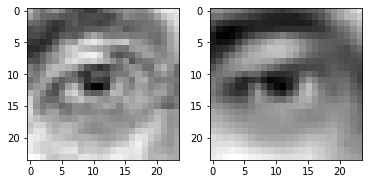

tensor([-6.9053e-02, -6.1612e-02,  1.9401e-02, -7.9143e-02,  7.7729e-02,
        -5.4849e-02, -1.0710e-01,  2.3379e-03, -1.8238e-01,  2.0745e-01,
         1.3712e-01, -1.0581e-01,  2.6881e-03, -3.9638e-02, -7.1458e-02,
        -6.1893e-02, -2.6860e-02,  1.5051e-01,  6.9445e-02,  5.1828e-02,
         1.5520e-01,  5.3369e-03,  1.7413e-02,  7.2589e-02, -2.4268e-01,
        -1.5436e-01, -1.7953e-04, -9.4945e-02,  2.2009e-02,  5.1949e-02,
        -7.8323e-02,  4.8032e-03, -1.7395e-02, -2.9595e-03,  1.0697e-01,
         1.4956e-01, -1.0056e-01, -7.7686e-02, -1.7964e-02, -1.5281e-01,
        -2.0717e-01, -3.1023e-01, -1.8405e-02, -2.4238e-02,  3.7585e-02,
        -1.5408e-02,  5.7693e-02, -5.0167e-02, -4.7767e-03, -8.3803e-02],
       device='cuda:0', grad_fn=<SelectBackward>)
5800 0.0019946792162954807 7.559900283813477 0.0023726741783320904


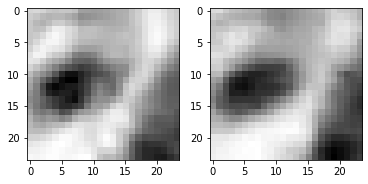

tensor([ 9.4844e-02, -1.2883e-02,  6.2996e-03,  4.3219e-02, -1.3868e-02,
         2.7073e-02,  1.3254e-01, -1.3559e-02,  5.5430e-02,  7.2024e-04,
        -8.5804e-02,  1.3055e-01,  2.2715e-03,  4.6890e-03, -1.2766e-02,
         4.7111e-03, -6.0062e-02,  1.6460e-01, -1.9252e-02,  1.6655e-02,
        -5.9005e-01,  2.1151e-03,  1.9600e-02,  1.3793e-02,  1.3477e-02,
        -5.8293e-03, -1.0437e-02, -4.8232e-03,  6.4799e-02, -2.1290e-04,
        -4.1318e-02,  1.9765e-02, -6.2037e-02,  1.1936e-02,  5.3423e-02,
         1.0676e-01, -2.2255e-02, -3.2201e-02, -1.0095e-03,  1.0544e-03,
        -7.9009e-02, -8.7412e-03,  2.3825e-03, -7.3461e-03, -1.4295e-02,
         5.1875e-03, -6.8648e-03, -7.3965e-03,  6.0455e-03,  7.2767e-03],
       device='cuda:0', grad_fn=<SelectBackward>)
5900 0.002153274603188038 7.627688407897949 0.0025346591137349606


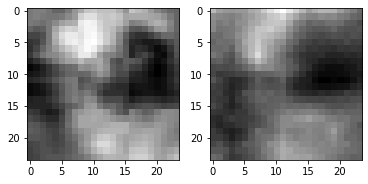

tensor([-0.0395,  0.0229, -0.0182,  0.0400, -0.0407,  0.0357, -0.2141,  0.0261,
        -0.1761, -0.0532, -0.0501, -0.0609, -0.0011,  0.0053,  0.0345,  0.0170,
         0.0558, -0.0374, -0.0943, -0.0201,  0.4164,  0.0123,  0.0030,  0.0434,
         0.0826, -0.0524,  0.0210,  0.1630, -0.0766, -0.0257,  0.0730, -0.0328,
        -0.1019,  0.0019, -0.0263, -0.0801,  0.0695,  0.0390,  0.0287,  0.0221,
        -0.1398, -0.0434,  0.0176, -0.1085,  0.0148,  0.0142,  0.0093,  0.0188,
        -0.0183,  0.0470], device='cuda:0', grad_fn=<SelectBackward>)
6000 0.0018792671617120504 7.034488677978516 0.0022309916093945503


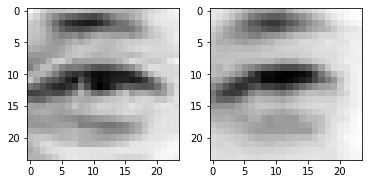

tensor([-0.1404, -0.0080,  0.0314,  0.0568, -0.0076,  0.0170,  0.1036, -0.0201,
         0.0303, -0.0260,  0.1406, -0.0420, -0.0152,  0.0168, -0.0118,  0.0145,
        -0.0305, -0.0805, -0.0091, -0.0077, -0.2907, -0.0170, -0.0276,  0.0161,
         0.0929,  0.0514, -0.0054,  0.0547,  0.0436,  0.0101,  0.0095,  0.0422,
        -0.0080,  0.0048, -0.0030, -0.0067, -0.0225, -0.0516, -0.0231, -0.0051,
        -0.0762, -0.0478, -0.0013,  0.1001,  0.0084, -0.0011, -0.0069,  0.0136,
         0.0082,  0.0687], device='cuda:0', grad_fn=<SelectBackward>)
6100 0.0018830823246389627 7.267131328582764 0.00224643899127841


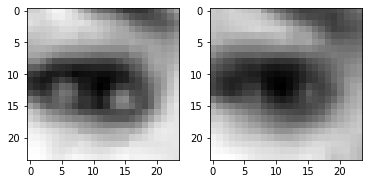

tensor([ 0.0295, -0.0305, -0.0681, -0.1392,  0.0723,  0.0924,  0.0388,  0.0818,
        -0.1076, -0.0290,  0.0407,  0.0200,  0.0306,  0.0307,  0.0429,  0.0445,
         0.0454,  0.2187,  0.0778, -0.0170, -0.0234,  0.0570, -0.0169,  0.0457,
        -0.1967, -0.1140,  0.0100, -0.0123, -0.0483, -0.0298, -0.0454,  0.0231,
        -0.0116, -0.0151,  0.0408, -0.0101,  0.0633, -0.1192,  0.0496,  0.0095,
         0.3456,  0.0671,  0.0472,  0.3394, -0.0524, -0.0186, -0.0148, -0.0302,
        -0.0212,  0.0786], device='cuda:0', grad_fn=<SelectBackward>)
6200 0.0028462158516049385 7.455832004547119 0.0032190075144171715


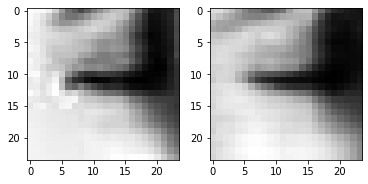

tensor([ 0.0350, -0.0208, -0.0209, -0.0249,  0.0197,  0.0141,  0.0246,  0.0232,
        -0.0370,  0.0502, -0.0642, -0.0099,  0.0023,  0.0017,  0.0206,  0.0179,
        -0.0112,  0.0270,  0.0058,  0.0032, -0.4201,  0.0173, -0.0038,  0.0313,
         0.0049, -0.0370, -0.0110, -0.0149, -0.0051,  0.0086, -0.0129,  0.0184,
         0.0360, -0.0062,  0.0965,  0.0295,  0.0143,  0.0161,  0.0192, -0.0812,
         0.0137, -0.0955,  0.0006,  0.0218, -0.0044,  0.0306, -0.0022,  0.0017,
        -0.0155,  0.0753], device='cuda:0', grad_fn=<SelectBackward>)
6300 0.0022008020896464586 7.416284561157227 0.0025716163218021393


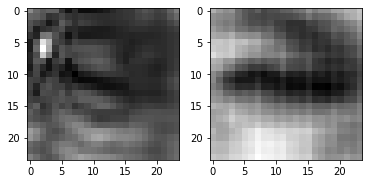

tensor([-0.1617, -0.0120,  0.0267, -0.0825, -0.0510,  0.0405,  0.0172,  0.0038,
        -0.0093, -0.1340,  0.1832, -0.1353, -0.0207, -0.0112, -0.0021,  0.0255,
        -0.1218,  0.0101, -0.0184, -0.0198,  0.0356, -0.0373,  0.0263,  0.0068,
         0.0184,  0.0024, -0.0362,  0.1049, -0.0203,  0.0291,  0.0228,  0.0314,
        -0.0347, -0.0183,  0.0754, -0.0906, -0.0188,  0.0883, -0.0102,  0.0444,
        -0.0681,  0.0042, -0.0048,  0.1309,  0.0066, -0.0277,  0.0013,  0.0328,
        -0.0032,  0.1640], device='cuda:0', grad_fn=<SelectBackward>)
6400 0.001930899336002767 7.440917015075684 0.002302945125848055


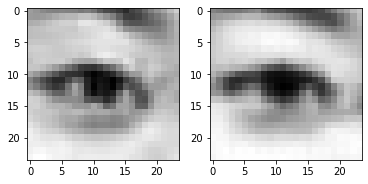

tensor([ 1.4071e-01,  6.1173e-03, -5.9077e-02, -7.4351e-02, -3.3836e-02,
        -2.3083e-02,  7.1883e-02,  1.1682e-02,  9.2098e-03, -4.2042e-02,
        -3.9023e-02, -3.2833e-02,  3.2607e-02,  1.4148e-02,  1.6914e-02,
        -2.4681e-04,  1.1577e-01, -2.3612e-01, -5.7397e-02,  4.9661e-03,
        -3.6814e-01,  1.5298e-02, -3.4961e-02,  3.7416e-02,  3.4998e-03,
        -7.3424e-02,  1.5415e-02, -1.3808e-02, -5.7787e-02, -1.2712e-03,
         1.4318e-02,  2.3868e-04, -1.2513e-02,  2.8162e-02,  9.9331e-03,
        -9.7161e-03, -2.2665e-02,  1.7352e-01,  3.4108e-02, -2.3311e-02,
         2.0704e-02,  4.4175e-03, -2.0227e-02, -2.7747e-02, -1.1499e-02,
         1.6136e-02,  8.4064e-04,  1.0995e-03, -4.6747e-02, -8.3737e-03],
       device='cuda:0', grad_fn=<SelectBackward>)
6500 0.002456600544974208 7.1724982261657715 0.0028152253944426775


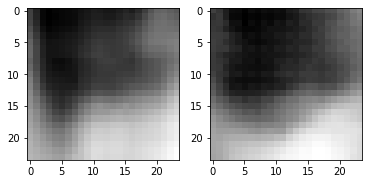

tensor([-0.0299, -0.0013, -0.0172,  0.0946, -0.0246, -0.0378,  0.1438, -0.0081,
         0.0271, -0.0076, -0.0683, -0.0588,  0.0133, -0.0026,  0.0226, -0.0127,
        -0.0498, -0.0855, -0.0180,  0.0073, -0.5056, -0.0107,  0.0067,  0.0288,
        -0.0536,  0.0071, -0.0060,  0.0435,  0.0641, -0.0026, -0.0038, -0.0222,
        -0.0630,  0.0039,  0.0045, -0.0519,  0.0055,  0.1633,  0.0066, -0.0606,
         0.0711, -0.0125, -0.0250, -0.0836, -0.0057,  0.0456,  0.0088,  0.0230,
        -0.0186, -0.0170], device='cuda:0', grad_fn=<SelectBackward>)
6600 0.002251848578453064 7.261806488037109 0.002614938886836171


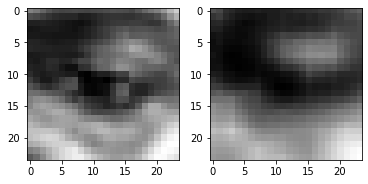

tensor([ 0.0333,  0.0080, -0.0091,  0.0159, -0.0321, -0.0188, -0.0189,  0.0059,
         0.0393, -0.0720, -0.1132,  0.0124, -0.0430,  0.0058, -0.0092, -0.0131,
        -0.0426,  0.0522, -0.0250,  0.0033,  0.2251,  0.0106,  0.0103, -0.0109,
         0.0600,  0.0395,  0.0079, -0.0381, -0.0176,  0.0239,  0.0234, -0.0268,
        -0.0568, -0.0238,  0.0291,  0.0548,  0.0200,  0.0078,  0.0112, -0.0010,
         0.1146,  0.1270,  0.0017, -0.1048, -0.0158,  0.0250, -0.0039,  0.0068,
        -0.0161, -0.0930], device='cuda:0', grad_fn=<SelectBackward>)
6700 0.002230639336630702 7.477230548858643 0.0026045008562505245


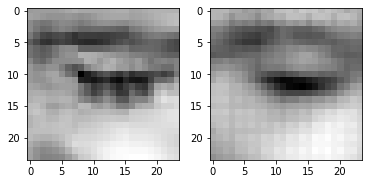

tensor([-2.2505e-01,  3.3048e-02,  2.8015e-02,  1.0573e-01,  4.7866e-02,
         1.1316e-02,  3.3166e-02,  6.8904e-02, -4.2887e-02,  4.7173e-02,
        -1.2013e-01,  5.6940e-02, -5.1347e-02,  4.7688e-02, -5.3644e-03,
         5.2659e-02,  5.6103e-02,  1.0171e-01,  6.6625e-02,  5.0702e-05,
        -6.1564e-02,  4.8263e-03,  1.4621e-02, -3.5258e-02, -1.0511e-01,
        -1.4779e-02,  1.1239e-02, -7.6043e-03,  2.0053e-01, -1.9361e-02,
         7.7082e-02, -4.6531e-02,  2.7673e-01, -4.8533e-02, -1.7906e-01,
        -1.3753e-01,  4.1909e-02, -1.0888e-01, -5.3476e-02, -1.2897e-01,
         8.4061e-02, -3.5568e-02,  1.1976e-01, -7.6377e-03,  2.2433e-02,
        -9.6863e-02, -3.6246e-02, -2.9732e-02, -7.0769e-03,  8.4562e-03],
       device='cuda:0', grad_fn=<SelectBackward>)
6800 0.0022626288700848818 7.921554088592529 0.0026587066240608692


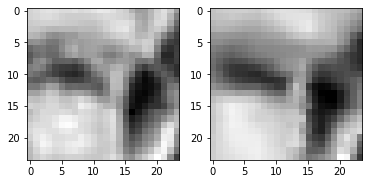

tensor([-0.0760, -0.0034, -0.0009,  0.0468,  0.0591,  0.0171, -0.0697, -0.0123,
        -0.0809, -0.0180,  0.0888,  0.0004, -0.0526,  0.0028,  0.0009, -0.0010,
         0.0583,  0.0184,  0.0629, -0.0183, -0.0741,  0.0121, -0.0076, -0.0155,
        -0.0174, -0.0652,  0.0129, -0.0638, -0.0164,  0.0105, -0.0213, -0.0048,
        -0.0075,  0.0118,  0.0157, -0.0023,  0.0258,  0.0484, -0.0087,  0.0342,
         0.1077, -0.0128, -0.0399, -0.0234, -0.0137, -0.0541, -0.0149, -0.0090,
        -0.0002,  0.0053], device='cuda:0', grad_fn=<SelectBackward>)
6900 0.002023655455559492 7.47376012802124 0.0023973435163497925


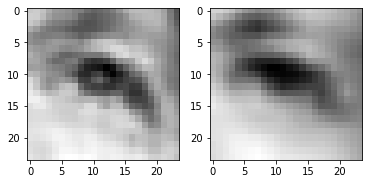

tensor([-2.1423e-04,  3.3444e-02,  9.2296e-03,  2.0484e-02, -1.1253e-01,
         2.3069e-02,  5.8680e-02, -2.7316e-02,  7.8416e-04,  8.4667e-02,
        -7.0809e-02,  3.4666e-02,  7.6370e-02,  6.1018e-02,  3.7164e-02,
        -1.1403e-01,  8.3026e-02,  2.3996e-02,  1.4157e-02, -2.2098e-02,
         7.9258e-01, -7.4237e-03, -2.7826e-03, -4.9759e-02, -2.0240e-01,
         8.6589e-02,  1.0250e-02, -1.7791e-02,  4.6772e-02, -1.2047e-01,
        -2.4851e-02,  1.2159e-02,  2.3309e-02,  2.4721e-02,  8.2890e-03,
        -4.5839e-02,  2.6271e-02,  7.0593e-03,  4.0533e-02, -9.5709e-02,
         1.2744e-01, -2.5342e-02,  6.5341e-02, -9.2686e-03,  2.9401e-02,
         1.4099e-03, -1.0914e-02, -7.8760e-02,  6.0210e-02, -1.5678e-01],
       device='cuda:0', grad_fn=<SelectBackward>)
7000 0.00236619939096272 7.608761787414551 0.0027466374449431896


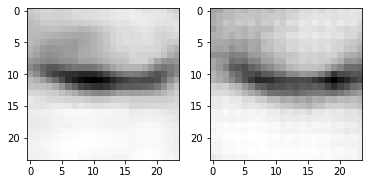

tensor([-0.1976,  0.0112,  0.0379,  0.0606, -0.0639,  0.0116, -0.0374,  0.0168,
        -0.1298, -0.0480,  0.0549,  0.1092,  0.0212,  0.0004, -0.0087, -0.0024,
         0.1205,  0.0461, -0.0461,  0.0095, -0.0620, -0.0112,  0.0074, -0.0047,
         0.0767, -0.0121,  0.0093, -0.0695, -0.0232, -0.0055, -0.0027,  0.0217,
         0.0229, -0.0037, -0.0634, -0.0041,  0.0176, -0.0898, -0.0087,  0.1036,
         0.0375, -0.0409, -0.0195,  0.0388,  0.0019,  0.0005,  0.0271, -0.0020,
         0.0256,  0.0402], device='cuda:0', grad_fn=<SelectBackward>)
7100 0.00283298478461802 7.092068672180176 0.0031875881832093


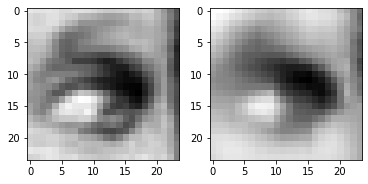

tensor([ 0.1003,  0.0233,  0.0212, -0.0190,  0.0663, -0.0084, -0.0735,  0.0196,
         0.0117, -0.0317, -0.0022, -0.0646, -0.0087, -0.0012,  0.0066,  0.0385,
        -0.0025, -0.0154, -0.0058, -0.0030, -0.1667,  0.0159, -0.0082, -0.0133,
        -0.0383, -0.0313, -0.0030, -0.0497,  0.0416,  0.0062, -0.0183, -0.0095,
         0.0553, -0.0115, -0.0597, -0.0023,  0.0137,  0.1477, -0.0028, -0.0635,
        -0.0936, -0.0589, -0.0063, -0.1263, -0.0057, -0.0546,  0.0113,  0.0182,
         0.0115,  0.0094], device='cuda:0', grad_fn=<SelectBackward>)
7200 0.0025235649663954973 7.070988178253174 0.0028771143406629562


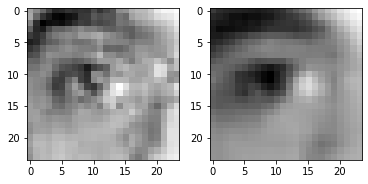

tensor([ 0.0701, -0.0078,  0.0174,  0.1248,  0.0327,  0.0097,  0.1385, -0.0348,
        -0.0281, -0.0245, -0.0581, -0.1096, -0.0183,  0.0273,  0.0139, -0.0026,
        -0.0543, -0.0701,  0.1557, -0.0290,  0.0098, -0.0096,  0.0219,  0.0104,
        -0.0887, -0.0582,  0.0007,  0.0957,  0.1335,  0.0076,  0.0168, -0.0027,
        -0.0372,  0.0044, -0.0181, -0.0712,  0.0015,  0.1061, -0.0104, -0.0240,
        -0.0980,  0.0589, -0.0059,  0.1859, -0.0112,  0.0299, -0.0257,  0.0428,
         0.0181, -0.0534], device='cuda:0', grad_fn=<SelectBackward>)
7300 0.0022671802435070276 7.2005815505981445 0.0026272092945873737


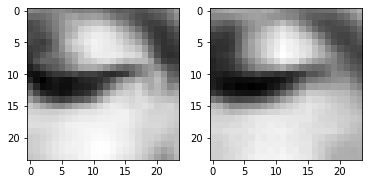

tensor([ 0.1170, -0.0062, -0.0165, -0.0590,  0.0135,  0.0023,  0.0403,  0.0062,
        -0.0444,  0.0976, -0.1643,  0.0845, -0.0265,  0.0116, -0.0194,  0.0128,
         0.0212, -0.3084,  0.1185,  0.0069, -0.2181,  0.0293, -0.0189,  0.0509,
        -0.1200, -0.0860, -0.0025, -0.0645,  0.0504,  0.0235,  0.0004, -0.0395,
         0.0172,  0.0082,  0.0757,  0.0708,  0.0034,  0.1734, -0.0277,  0.0436,
         0.0998, -0.0522,  0.0272,  0.1509,  0.0070,  0.0684,  0.0038, -0.0040,
         0.0011, -0.0896], device='cuda:0', grad_fn=<SelectBackward>)
7400 0.0021637824829667807 7.281833648681641 0.002527874195948243


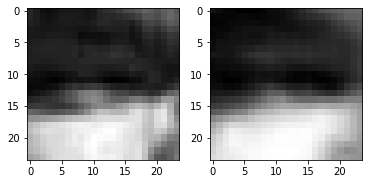

tensor([ 0.0882,  0.0139,  0.0007,  0.0361,  0.0531,  0.0185, -0.0974, -0.0126,
        -0.0456, -0.0110, -0.0084, -0.0508,  0.0020,  0.0057, -0.0086,  0.0016,
        -0.0276,  0.0859, -0.0141, -0.0065, -0.0165, -0.0005,  0.0027,  0.0127,
         0.1316,  0.0453,  0.0046,  0.0011, -0.0558,  0.0022, -0.0080, -0.0046,
        -0.0432,  0.0143,  0.0394, -0.0031,  0.0233,  0.0144,  0.0032,  0.0269,
         0.0621, -0.0404, -0.0120, -0.0277,  0.0217,  0.0004, -0.0011,  0.0106,
        -0.0028, -0.0478], device='cuda:0', grad_fn=<SelectBackward>)
7500 0.002479352755472064 7.237277507781982 0.0028412165120244026


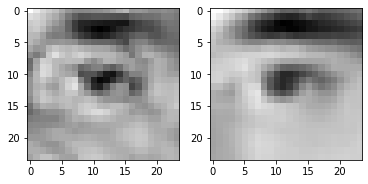

tensor([ 0.0569,  0.0221, -0.0080,  0.0670,  0.0477, -0.0264, -0.0189, -0.0071,
         0.0089, -0.0105, -0.0529,  0.0278,  0.0139,  0.0178,  0.0294,  0.0065,
         0.0476,  0.2396, -0.0067, -0.0077,  0.1628, -0.0399,  0.0166,  0.0432,
         0.1049,  0.0579,  0.0200, -0.0639,  0.0106, -0.0231, -0.0062,  0.0150,
         0.0095, -0.0166, -0.0174,  0.0500, -0.0037,  0.0091, -0.0053, -0.0837,
        -0.0489,  0.0142,  0.0079, -0.0401, -0.0046,  0.0325, -0.0081,  0.0255,
         0.0018, -0.1060], device='cuda:0', grad_fn=<SelectBackward>)
7600 0.002565611619502306 7.320653915405273 0.002931644208729267


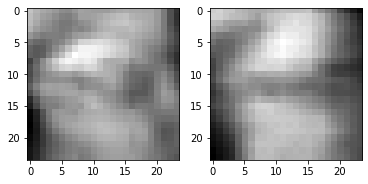

tensor([-0.0314,  0.0154,  0.0042,  0.0067, -0.0124, -0.0050,  0.0951, -0.0005,
        -0.0395,  0.0099, -0.0610,  0.0188, -0.0190,  0.0136, -0.0025, -0.0033,
         0.0315,  0.1284, -0.0646, -0.0251,  0.1062, -0.0021,  0.0474, -0.0208,
        -0.0128,  0.0253, -0.0099,  0.0518, -0.0537,  0.0353, -0.0038, -0.0209,
        -0.0607, -0.0173,  0.0217,  0.0611,  0.0189, -0.0297,  0.0114,  0.1014,
         0.0035,  0.0578,  0.0130,  0.0303, -0.0102, -0.0171,  0.0241,  0.0164,
        -0.0107, -0.0214], device='cuda:0', grad_fn=<SelectBackward>)
7700 0.0032917854841798544 7.271813869476318 0.0036553761456161737


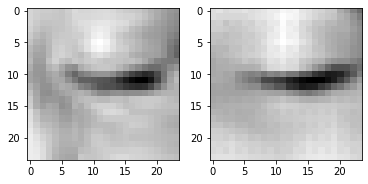

tensor([-0.0249, -0.0317, -0.0009,  0.0801,  0.0486,  0.0054,  0.0944, -0.0030,
         0.0997,  0.0319, -0.0956,  0.0774,  0.0225, -0.0225,  0.0081,  0.0075,
         0.0175,  0.1215, -0.0047,  0.0335,  0.3159,  0.0202, -0.0307, -0.0248,
         0.0135, -0.0226,  0.0156, -0.0228,  0.1342, -0.0073, -0.0290,  0.0062,
        -0.0454,  0.0027, -0.0565,  0.0057, -0.0145, -0.0800,  0.0308,  0.0236,
        -0.0608,  0.0322, -0.0125, -0.1604,  0.0111, -0.0408, -0.0054, -0.0191,
        -0.0325, -0.0868], device='cuda:0', grad_fn=<SelectBackward>)
7800 0.003956216853111982 7.385724067687988 0.004325503017753363


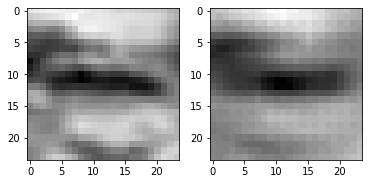

tensor([ 0.0042, -0.0238, -0.0162, -0.0472,  0.0437,  0.0080,  0.0552, -0.0094,
         0.0488, -0.0448, -0.0370,  0.0462,  0.0063, -0.0279,  0.0140, -0.0201,
         0.0552, -0.1282, -0.0733,  0.0327,  0.0559,  0.0112, -0.0312, -0.0049,
         0.0625,  0.0466,  0.0177, -0.0088, -0.0439, -0.0182, -0.0017,  0.0170,
        -0.0137,  0.0078, -0.0072, -0.0851, -0.0130, -0.1504,  0.0120, -0.0096,
        -0.0158, -0.0061, -0.0302,  0.0331,  0.0314, -0.0402, -0.0148, -0.0253,
        -0.0237,  0.1276], device='cuda:0', grad_fn=<SelectBackward>)
7900 0.0020961719565093517 7.610045909881592 0.00247667427174747


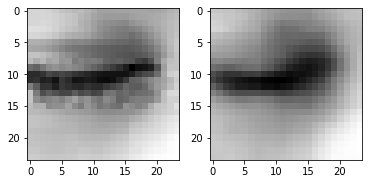

tensor([ 0.1208, -0.0059, -0.0068, -0.0033,  0.0603, -0.0019,  0.0257, -0.0008,
        -0.0239, -0.0190,  0.0303,  0.0413, -0.0068,  0.0187, -0.0200,  0.0217,
        -0.0024,  0.0650, -0.1026,  0.0006,  0.3705,  0.0185,  0.0038,  0.0310,
        -0.0490,  0.0055,  0.0021,  0.0067,  0.0005,  0.0093, -0.0014,  0.0279,
         0.0410, -0.0128, -0.0168,  0.0302, -0.0075, -0.0259, -0.0156,  0.0013,
         0.0682,  0.0673,  0.0255, -0.0219,  0.0087, -0.0016, -0.0072,  0.0058,
        -0.0193, -0.0187], device='cuda:0', grad_fn=<SelectBackward>)
8000 0.0022425369825214148 7.4030985832214355 0.0026126918382942677


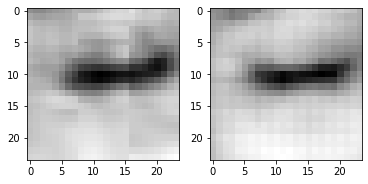

tensor([-3.9676e-03, -1.5114e-02, -1.0897e-02,  5.5361e-03, -1.3361e-02,
        -1.6026e-02, -1.4046e-02, -1.3756e-02, -5.9983e-02, -3.0745e-02,
         4.1424e-02,  1.0028e-01,  1.2389e-02,  9.3012e-05, -1.9650e-03,
         3.0444e-03,  8.0446e-02, -1.0571e-01,  5.7987e-03,  2.9474e-02,
        -2.2843e-02,  1.3767e-02, -1.1400e-02, -4.0744e-02, -5.9265e-02,
         6.0811e-02, -2.3330e-02,  1.4850e-01,  3.0426e-02, -1.5299e-02,
         7.2648e-03, -1.0008e-02,  2.2258e-03,  1.5116e-02, -9.3405e-03,
         2.7904e-02,  2.7195e-03,  5.8730e-02, -1.2642e-02,  3.7877e-03,
        -3.0614e-03, -2.2667e-02, -1.4914e-02, -3.5312e-02,  1.8342e-02,
        -2.1209e-02, -2.1079e-02, -5.5792e-03, -2.3192e-03,  8.6597e-03],
       device='cuda:0', grad_fn=<SelectBackward>)
8100 0.0033014672808349133 7.03587532043457 0.003653261112049222


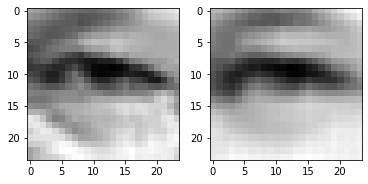

tensor([ 0.0122, -0.0123, -0.0235, -0.0152,  0.0162,  0.0003,  0.0187, -0.0087,
         0.0164, -0.0476,  0.0659, -0.0735, -0.0042, -0.0032, -0.0040,  0.0377,
        -0.0033, -0.0319, -0.0262,  0.0103, -0.1624,  0.0028, -0.0258,  0.0175,
         0.0597, -0.0531, -0.0080, -0.0646, -0.0190, -0.0051, -0.0200, -0.0078,
         0.0119,  0.0163, -0.0176, -0.1211,  0.0055,  0.0042, -0.0172, -0.0073,
        -0.0245, -0.0433,  0.0019, -0.0021,  0.0132, -0.0668, -0.0057,  0.0159,
        -0.0229,  0.1424], device='cuda:0', grad_fn=<SelectBackward>)
8200 0.002170165302231908 7.236076354980469 0.0025319689884781837


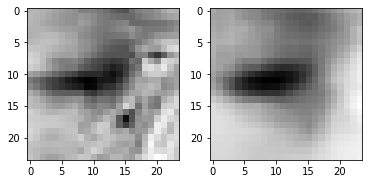

tensor([-1.0417e-01, -1.0838e-02, -1.1182e-02,  3.4661e-02,  7.0391e-02,
         9.5209e-03,  5.6437e-02,  5.9960e-03, -1.4752e-01,  6.6399e-03,
         6.1157e-02, -8.0318e-03,  1.3485e-02, -2.7997e-02, -1.7110e-02,
        -3.1543e-02,  3.4283e-02,  4.0208e-02, -9.6502e-02, -2.1843e-02,
         1.4041e-03,  4.8145e-02, -1.3215e-02, -3.1019e-04, -1.9137e-02,
        -2.7895e-02,  4.8831e-02,  2.6333e-02, -3.2227e-02, -2.1490e-03,
         3.7538e-02, -2.4012e-02, -9.0561e-02,  9.8959e-03,  7.4350e-03,
        -1.9306e-02,  2.9739e-03,  4.9585e-02,  1.9061e-02, -3.9903e-02,
         4.3148e-05, -1.5900e-02, -3.3164e-02, -3.6388e-02,  1.3531e-02,
        -5.4214e-03, -1.6184e-02, -2.5312e-02, -7.0932e-03, -4.1953e-02],
       device='cuda:0', grad_fn=<SelectBackward>)
8300 0.0022820208687335253 7.153850078582764 0.002639713464304805


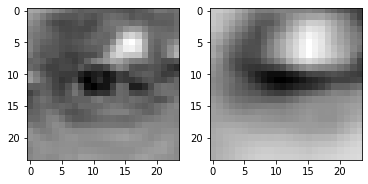

tensor([ 0.0566, -0.0033, -0.0081, -0.0008,  0.0601,  0.0133,  0.0307,  0.0204,
        -0.0408, -0.0109, -0.0031,  0.0650, -0.0130,  0.0174, -0.0005,  0.0016,
         0.0176,  0.0708, -0.0772,  0.0062, -0.0084,  0.0046,  0.0114, -0.0356,
         0.0301,  0.0462, -0.0013, -0.0262,  0.0456, -0.0050,  0.0089, -0.0042,
        -0.0641,  0.0085,  0.0402,  0.0106,  0.0062, -0.0451, -0.0116,  0.0056,
         0.0516,  0.0725, -0.0178,  0.0413,  0.0135,  0.0067, -0.0098,  0.0098,
        -0.0149, -0.0382], device='cuda:0', grad_fn=<SelectBackward>)
8400 0.002122878096997738 6.961817741394043 0.0024709689896553755


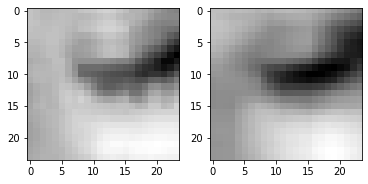

tensor([ 7.2326e-02, -9.1909e-03,  2.1813e-03,  2.0487e-02, -9.6458e-02,
        -1.1207e-02, -1.6078e-02, -3.3037e-03, -4.0520e-02,  1.5479e-02,
        -5.1998e-02, -5.3326e-02,  7.7731e-03, -5.0424e-03, -1.0920e-02,
         1.9723e-02,  1.7031e-02,  1.1028e-01,  1.1586e-02,  3.6690e-03,
        -7.4644e-02,  1.1111e-02,  5.5892e-04, -2.3604e-02,  9.1651e-03,
        -2.6305e-02, -1.3375e-02, -5.1980e-02, -1.9333e-02,  1.1352e-03,
         3.1798e-02, -2.2417e-03, -3.6071e-02, -1.5506e-02, -5.9344e-02,
         5.1816e-03, -8.0677e-03, -2.0747e-02, -2.1160e-03,  2.9361e-02,
        -6.1781e-02, -4.3437e-05,  3.5321e-03, -1.2498e-02, -7.2696e-03,
         4.8378e-02, -5.2673e-03, -2.7790e-02,  2.2877e-03, -2.3892e-02],
       device='cuda:0', grad_fn=<SelectBackward>)
8500 0.0019089573761448264 7.025593280792236 0.0022602370008826256


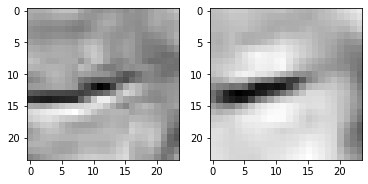

tensor([ 0.1274, -0.0098, -0.0100,  0.0025, -0.1545, -0.0104, -0.0025,  0.0016,
         0.0438,  0.1742, -0.0018, -0.2452, -0.0166, -0.0062,  0.0029, -0.0219,
         0.1557, -0.2831, -0.0801,  0.0032, -0.3285, -0.0104,  0.0056, -0.0323,
        -0.0313, -0.1091,  0.0075,  0.0501,  0.0530,  0.0232,  0.0163,  0.0272,
         0.1700, -0.0021, -0.1505, -0.0231, -0.0434,  0.0764,  0.0110, -0.1857,
        -0.0122,  0.0697, -0.0230, -0.0725,  0.0047, -0.0100, -0.0222, -0.0097,
        -0.0081, -0.0973], device='cuda:0', grad_fn=<SelectBackward>)
8600 0.0017283778870478272 6.796863079071045 0.002068221103399992


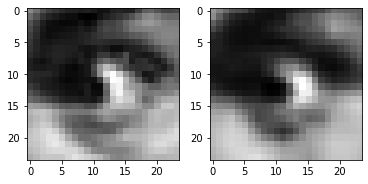

tensor([ 0.0376,  0.0297, -0.0607, -0.0488,  0.0357, -0.0531, -0.0132, -0.0089,
        -0.0203,  0.0305,  0.0575, -0.0796,  0.0135, -0.0256, -0.0053, -0.0350,
         0.0116, -0.0474,  0.0134, -0.0128, -0.1653, -0.0797, -0.0392,  0.0197,
        -0.0013,  0.0036, -0.0431,  0.0804,  0.0230, -0.0942,  0.0317,  0.0008,
         0.0355, -0.0037, -0.0012, -0.0756, -0.0110, -0.0144, -0.0037,  0.0209,
        -0.1087,  0.0202,  0.0047, -0.0532, -0.0337,  0.1269, -0.0043,  0.0042,
        -0.0072,  0.0462], device='cuda:0', grad_fn=<SelectBackward>)
8700 0.0022288223262876272 7.286404132843018 0.002593142446130514


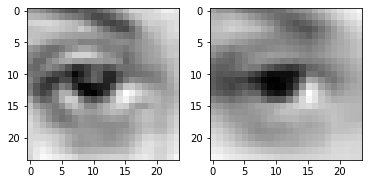

tensor([-0.0974, -0.0210,  0.0053, -0.0048,  0.0059,  0.0071,  0.0061, -0.0170,
         0.0553, -0.0035, -0.0189,  0.0964,  0.0149, -0.0153,  0.0181,  0.0298,
        -0.0294,  0.1791,  0.0588, -0.0020, -0.4017, -0.0142,  0.0034, -0.0258,
        -0.0424,  0.0040,  0.0047, -0.0893,  0.0112,  0.0135,  0.0079,  0.0243,
        -0.0399, -0.0044, -0.0476, -0.0125,  0.0051,  0.0690,  0.0100, -0.0127,
        -0.0917, -0.0254, -0.0075,  0.0048,  0.0054,  0.0216, -0.0138,  0.0048,
         0.0317,  0.0113], device='cuda:0', grad_fn=<SelectBackward>)
8800 0.0029962093103677034 7.099129676818848 0.0033511659130454063


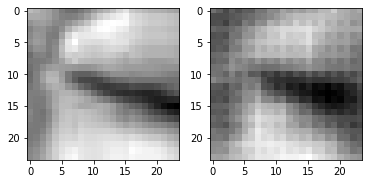

tensor([ 0.0007, -0.0173,  0.0065,  0.0517,  0.0382, -0.0052, -0.0205, -0.0090,
        -0.0910, -0.0548, -0.0383, -0.0671, -0.0395, -0.0055, -0.0176, -0.0201,
        -0.0485, -0.0937,  0.0256, -0.0205, -0.1130,  0.0232,  0.0485,  0.0128,
         0.0764, -0.1028,  0.0133,  0.1103, -0.0971,  0.0339,  0.0184, -0.0049,
        -0.0986, -0.0288, -0.0424, -0.0016,  0.0033,  0.0828,  0.0077,  0.0559,
        -0.0422, -0.0290,  0.0170, -0.1059, -0.0149, -0.0673,  0.0256, -0.0165,
         0.0155,  0.0763], device='cuda:0', grad_fn=<SelectBackward>)
8900 0.002045917557552457 7.177692890167236 0.002404802246019244


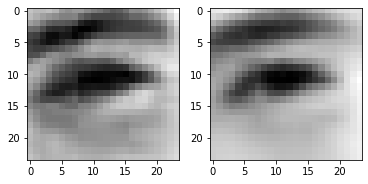

tensor([ 0.0386,  0.0104, -0.0020,  0.0481,  0.0180, -0.0131, -0.0364, -0.0163,
        -0.0375,  0.0515,  0.0415, -0.0934,  0.0002, -0.0070,  0.0218, -0.0068,
        -0.0868, -0.0365,  0.0137,  0.0145, -0.0963,  0.0002, -0.0015,  0.0014,
        -0.1195,  0.0209, -0.0268,  0.1718,  0.0860, -0.0054,  0.0179,  0.0037,
        -0.0173, -0.0041,  0.1067,  0.0602,  0.0139,  0.0343,  0.0223, -0.1309,
        -0.0986,  0.0579,  0.0102, -0.1266,  0.0080,  0.0876, -0.0055,  0.0103,
         0.0072,  0.0195], device='cuda:0', grad_fn=<SelectBackward>)
9000 0.002168898470699787 7.286672592163086 0.002533232094720006


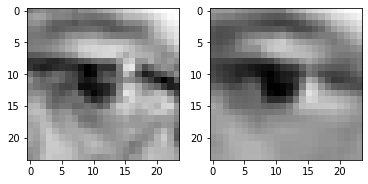

tensor([ 0.0217, -0.0088,  0.0331, -0.1210, -0.0584,  0.0337, -0.0850,  0.0547,
        -0.0301,  0.0386,  0.0766,  0.0287,  0.0242,  0.0199, -0.0244,  0.0060,
         0.0715, -0.1138, -0.0546, -0.0179, -0.1198,  0.0156,  0.0298,  0.0368,
         0.0435,  0.0397,  0.0052,  0.0469,  0.1081, -0.0094,  0.0160, -0.0002,
        -0.0323, -0.0029,  0.0865, -0.0129, -0.0020, -0.0662,  0.0134,  0.0038,
        -0.0416,  0.0112,  0.0367,  0.0433,  0.0099, -0.0386,  0.0504, -0.0030,
         0.0056, -0.0413], device='cuda:0', grad_fn=<SelectBackward>)
9100 0.002504142699763179 7.458401679992676 0.002877062652260065


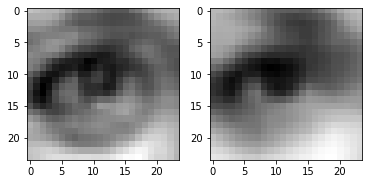

tensor([-0.1020,  0.0095,  0.0213, -0.0246, -0.1143,  0.0310, -0.1322, -0.0453,
         0.0892,  0.0563,  0.0583, -0.1464,  0.0177,  0.0124, -0.0141, -0.0012,
        -0.0436,  0.1089,  0.0382,  0.0430,  0.7860,  0.0023, -0.0376,  0.0343,
         0.0290,  0.0307,  0.0033, -0.0277, -0.0011,  0.0130, -0.0143,  0.0805,
        -0.1476,  0.0187,  0.0232, -0.0755,  0.0338,  0.1408,  0.0145, -0.2566,
         0.2566, -0.2415,  0.0361, -0.0173,  0.0378, -0.0146, -0.0274,  0.0235,
         0.0080, -0.1618], device='cuda:0', grad_fn=<SelectBackward>)
9200 0.001845265389420092 6.952053546905518 0.0021928681526333094


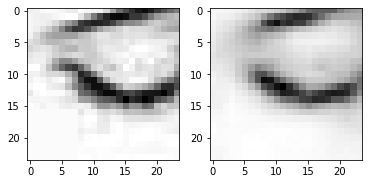

tensor([-0.0132,  0.0044,  0.0077,  0.0569,  0.0677, -0.0008, -0.0659,  0.0018,
        -0.0474, -0.0184, -0.0080, -0.0710,  0.0015, -0.0066,  0.0027,  0.0078,
        -0.0950,  0.1088,  0.0764,  0.0248,  0.1710,  0.0163, -0.0052, -0.0036,
        -0.0305, -0.0190,  0.0087, -0.0107, -0.0884, -0.0071,  0.0052,  0.0006,
        -0.0841,  0.0002, -0.0164, -0.0537,  0.0018, -0.0019,  0.0184, -0.0039,
        -0.0966, -0.0324, -0.0147, -0.1007, -0.0216,  0.0714,  0.0036,  0.0084,
        -0.0020, -0.0047], device='cuda:0', grad_fn=<SelectBackward>)
9300 0.0026108429301530123 6.971635341644287 0.0029594246298074722


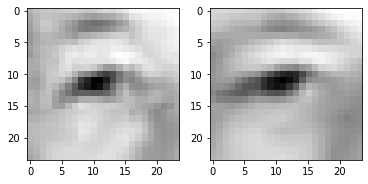

tensor([ 0.0359,  0.0360,  0.0089,  0.0077,  0.0340,  0.0069, -0.0046, -0.0129,
         0.0206,  0.0334, -0.0716, -0.0889,  0.0236,  0.0002, -0.0090,  0.0200,
         0.0484, -0.1170,  0.0796,  0.0280, -0.1079, -0.0187, -0.0543, -0.0793,
         0.0002,  0.0234,  0.0356,  0.0260, -0.0924,  0.0029, -0.0102,  0.0016,
        -0.0629,  0.0354,  0.0674,  0.0392,  0.0043,  0.0549, -0.0102, -0.0351,
        -0.0315,  0.0410, -0.0512,  0.1340,  0.0312, -0.0215, -0.0279,  0.0338,
        -0.0825,  0.0310], device='cuda:0', grad_fn=<SelectBackward>)
9400 0.001937905908562243 7.405876159667969 0.0023081996478140354


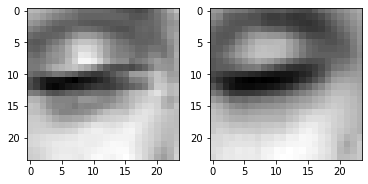

tensor([-0.0608,  0.0052,  0.0137,  0.0506,  0.0722,  0.0024,  0.0679,  0.0224,
        -0.0431, -0.0495, -0.0092, -0.0255, -0.0060,  0.0210, -0.0158, -0.0108,
         0.0451,  0.0714,  0.0259,  0.0049, -0.2140,  0.0009, -0.0005, -0.0205,
         0.0550, -0.0547,  0.0027, -0.0137, -0.0430, -0.0087,  0.0137, -0.0104,
         0.0292, -0.0038,  0.0778, -0.0056,  0.0006, -0.0478, -0.0036,  0.0284,
         0.0157,  0.0175, -0.0140, -0.0034, -0.0076,  0.0079,  0.0010, -0.0005,
        -0.0170, -0.0917], device='cuda:0', grad_fn=<SelectBackward>)
9500 0.0020539197139441967 7.2780585289001465 0.002417822601273656


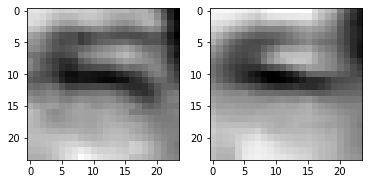

tensor([-0.0424, -0.0187,  0.0133, -0.0828, -0.0259,  0.0130, -0.0049,  0.0192,
         0.0046, -0.0088,  0.0260, -0.0765, -0.0014,  0.0102, -0.0022,  0.0066,
        -0.0044, -0.0776, -0.0451, -0.0187, -0.1384,  0.0154,  0.0068, -0.0098,
        -0.0617, -0.0165,  0.0073,  0.0210, -0.0211, -0.0016, -0.0020, -0.0142,
        -0.0267, -0.0043, -0.0385,  0.0150, -0.0210,  0.0792, -0.0064, -0.0191,
         0.0684,  0.0267,  0.0058, -0.0766, -0.0147,  0.0514,  0.0055, -0.0170,
        -0.0077, -0.0317], device='cuda:0', grad_fn=<SelectBackward>)
9600 0.002176363952457905 6.895567893981934 0.002521142363548279


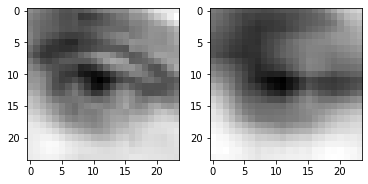

tensor([ 0.0476,  0.0052,  0.0148,  0.0041,  0.0379, -0.0224, -0.0174,  0.0085,
        -0.0868,  0.0368,  0.0487,  0.0931,  0.0244,  0.0197,  0.0038, -0.0062,
        -0.0344, -0.0670,  0.0403, -0.0334,  0.0066,  0.0057,  0.0112, -0.0455,
         0.1172, -0.0019,  0.0032, -0.0322, -0.0402, -0.0029, -0.0210,  0.0443,
         0.0178, -0.0047, -0.0089,  0.0001,  0.0169, -0.0481, -0.0488, -0.0395,
        -0.0190,  0.0037,  0.0278,  0.0713,  0.0065,  0.0077, -0.0079,  0.0242,
        -0.0162, -0.0445], device='cuda:0', grad_fn=<SelectBackward>)
9700 0.0017158538103103638 7.226302146911621 0.00207716878503561


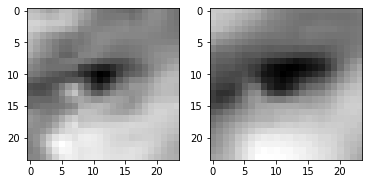

tensor([ 0.0131, -0.0031, -0.0040,  0.0030, -0.0336, -0.0090,  0.0220,  0.0002,
         0.0279, -0.0443,  0.0373, -0.0898, -0.0072, -0.0142,  0.0068,  0.0004,
        -0.0921,  0.0419,  0.0175,  0.0010,  0.0586, -0.0016,  0.0050, -0.0069,
        -0.0573, -0.0400, -0.0213, -0.0508,  0.0474, -0.0221, -0.0039,  0.0200,
        -0.0235, -0.0058, -0.0131,  0.0259, -0.0399,  0.0875,  0.0069, -0.0366,
        -0.0479,  0.0887,  0.0293,  0.1268, -0.0096,  0.0328,  0.0110,  0.0051,
         0.0128,  0.0937], device='cuda:0', grad_fn=<SelectBackward>)
9800 0.0017923100385814905 6.896048545837402 0.002137112431228161


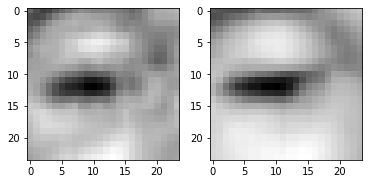

tensor([-3.2293e-02,  5.3678e-02,  2.2099e-02,  4.1692e-02, -6.7985e-02,
         4.0414e-02,  7.1535e-02, -1.4488e-02,  2.3514e-02,  2.7514e-02,
         3.9703e-02, -6.2741e-03, -9.0384e-03,  1.8940e-02, -8.9724e-03,
        -1.4869e-02, -5.1597e-02,  1.1488e-01,  1.8807e-04,  2.4416e-02,
         2.1279e-01, -1.5064e-02, -3.4263e-02,  2.5530e-02, -2.3197e-02,
         4.4449e-02, -1.5815e-02, -1.2615e-01,  8.8954e-03,  3.1336e-03,
         1.1010e-02,  1.5779e-02,  1.2235e-02,  4.0593e-02, -1.0403e-01,
        -1.2070e-02,  3.5676e-02,  1.0739e-01,  1.7875e-02, -1.1566e-01,
         6.9224e-02, -8.0506e-02, -1.1574e-02,  2.7034e-02, -1.1545e-02,
        -3.2915e-02, -9.1922e-03,  4.5789e-02, -8.5507e-03, -1.1301e-01],
       device='cuda:0', grad_fn=<SelectBackward>)
9900 0.0028332131914794445 7.426974296569824 0.003204561769962311


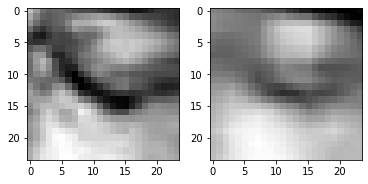

tensor([-0.0725, -0.0018, -0.0098, -0.0834,  0.0614, -0.0147,  0.0970,  0.0057,
        -0.0009,  0.0005,  0.0782,  0.0813, -0.0012, -0.0044,  0.0071, -0.0011,
        -0.0461, -0.0185,  0.0552, -0.0106,  0.1123, -0.0147,  0.0083, -0.0338,
         0.0469, -0.0099,  0.0020,  0.0842, -0.0470, -0.0242,  0.0017, -0.0234,
         0.0123, -0.0159, -0.0447,  0.0888,  0.0010, -0.0100,  0.0006,  0.0223,
         0.0566, -0.0139, -0.0023, -0.0714,  0.0088, -0.0553,  0.0006, -0.0083,
        -0.0064,  0.0770], device='cuda:0', grad_fn=<SelectBackward>)
10000 0.001473063719458878 7.0851216316223145 0.0018273198511451483


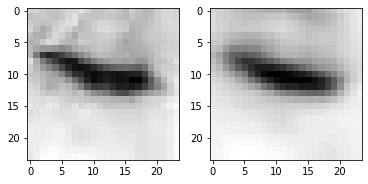

In [40]:
class VaeTrainer:
    def __init__(self, latent_size):
        self.vae = VAE(latent_size=latent_size)
        self.vae.cuda()
    
    def train(self):
        self.vae.train()
        
        image_list, _ = load_archive()
        
        tensor_data = (1/255*torch.tensor(image_list).float()).unsqueeze(1)

        dataset = torch.utils.data.TensorDataset(tensor_data)
        
        loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)
        
        optimizer = torch.optim.Adam(self.vae.parameters(), lr=1e-2)
        
        num_iters = 10_000
        i_iter = 0
        while i_iter < num_iters:
            for i_batch, (batch,) in enumerate(loader):
                batch = batch.cuda()
                pred_batch, z_batch = self.vae(batch)
                # print(z_batch)
                optimizer.zero_grad()
                loss_recon = F.mse_loss(batch, pred_batch)
                z_norm_loss = torch.norm(z_batch)
                loss = loss_recon + 0.5e-4*z_norm_loss
                loss.backward()
                optimizer.step()
                if i_iter % 100 == 0:
                    print(z_batch[0, ...])
                    print(i_iter, loss_recon.item(), z_norm_loss.item(), loss.item())
                    fig, axs = plt.subplots(1, 2)
                    axs[0].imshow(batch[0, 0, ...].detach().cpu().numpy(), cmap='gray')
                    axs[1].imshow(pred_batch[0, 0, ...].detach().cpu().numpy(), cmap='gray')
                    plt.show()
                    torch.save(self.vae.state_dict(), "vae.pth")
                i_iter += 1

latent_size = 50
vae_trainer = VaeTrainer(latent_size=latent_size)
vae_trainer.train()

In [46]:
class Classifier(nn.Module):
    def __init__(self, latent_size, pretrained_model_path="vae.pth"):
        super().__init__()
        self.encoder = Encoder(latent_size)
        if True:
            state_dict = torch.load(pretrained_model_path)
            # print(state_dict.keys())
            state_dict = {k[len("encoder."):]: v
                          for k, v in state_dict.items() if "encoder." in k}
            # print(state_dict.keys())
            self.encoder.load_state_dict(state_dict, strict=True)
        self.encoder.eval()
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.class_fc = nn.Linear(latent_size, 1)
    
    def forward(self, x):
        with torch.no_grad():
            mu, log_var = self.encoder(x)
        # print("mu=", mu)
        logits = self.class_fc(mu)
        # print("logits=", logits)
        x = torch.sigmoid(logits)
        x = x.squeeze(-1)
        return x
    
    def train(self, mode=True):
        self.encoder.train(False)
        self.class_fc.train(mode)

len(all_params) 22
len(optimizable_params) 2
0  train_loss= 0.6942502856254578
train_accuracy= 0.4642857313156128


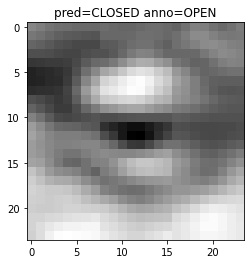

val_loss= 0.6984345316886902
val_accuracy= 0.6666666865348816
1000  train_loss= 0.17643114924430847
train_accuracy= 1.0


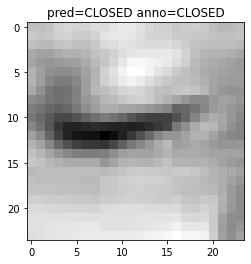

val_loss= 0.45999106764793396
val_accuracy= 0.75
2000  train_loss= 0.10909249633550644
train_accuracy= 1.0


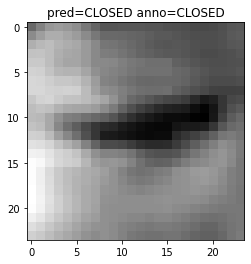

val_loss= 0.4437043368816376
val_accuracy= 0.8333333730697632
3000  train_loss= 0.08648873120546341
train_accuracy= 1.0


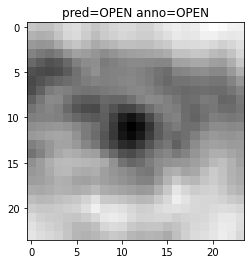

val_loss= 0.4188862442970276
val_accuracy= 0.8333333730697632
4000  train_loss= 0.07701502740383148
train_accuracy= 1.0


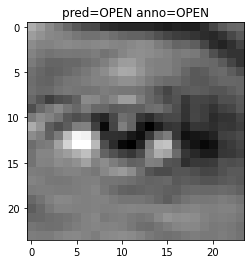

val_loss= 0.39530691504478455
val_accuracy= 0.8333333730697632
5000  train_loss= 0.07322026789188385
train_accuracy= 1.0


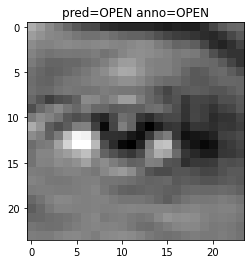

val_loss= 0.3818036913871765
val_accuracy= 0.8333333730697632
6000  train_loss= 0.07201249897480011
train_accuracy= 1.0


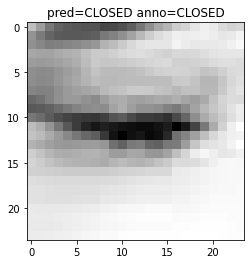

val_loss= 0.37458524107933044
val_accuracy= 0.8333333730697632
7000  train_loss= 0.07176392525434494
train_accuracy= 1.0


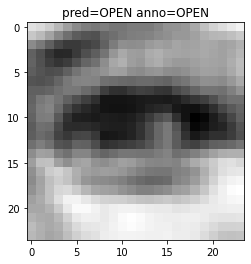

val_loss= 0.3722798824310303
val_accuracy= 0.8333333730697632
8000  train_loss= 0.07174235582351685
train_accuracy= 1.0


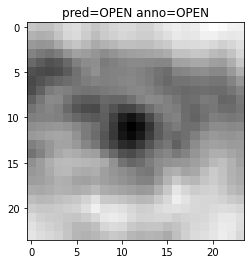

val_loss= 0.37204810976982117
val_accuracy= 0.8333333730697632
9000  train_loss= 0.07174189388751984
train_accuracy= 1.0


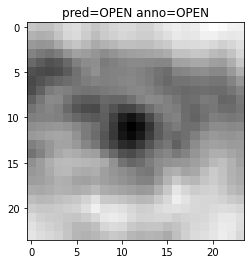

val_loss= 0.3720547556877136
val_accuracy= 0.8333333730697632


In [50]:
class ClassifierTrainer:
    def __init__(self):
        self.model = Classifier(latent_size)
        self.model.cuda()
        
    def _load_dataset(self, is_train):
        with open("annotation.json", "r") as f:
            dataset = json.load(f)
        flat_list = []
        for label, lst in dataset.items():
            val_div = 3
            if is_train:
                lst = lst[len(lst)//val_div:]
            else:
                lst = lst[:len(lst)//val_div]
            if label == "open":
                for name in lst:
                    flat_list.append(("train/"+name, 1))
            else:
                for name in lst:
                    flat_list.append(("train/"+name, 0))
        image_list, filenames = load_archive()
        name_to_image = dict(zip(filenames, image_list))
        anno_images = []
        for anno_name, anno_label in flat_list:
            if anno_name in name_to_image:
                anno_images.append(name_to_image[anno_name])
            else:
                print("Warning: file not found")
        images_np = np.array(anno_images)
        images_np = 1/255*np.expand_dims(images_np, 1)
        anno_np = np.array([v[1] for v in flat_list])
        dataset = torch.utils.data.TensorDataset(
            torch.tensor(images_np, dtype=torch.float32),
            torch.tensor(anno_np, dtype=torch.float32))
        return dataset

    def train(self):
        
        train_dataset = self._load_dataset(True)
        val_dataset = self._load_dataset(False)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset),
            shuffle=True, num_workers=0, drop_last=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset),
            shuffle=False, num_workers=0, drop_last=True)
        
        all_params = list(self.model.parameters())
        print("len(all_params)", len(all_params))
        
        optimizable_params = [p for p in self.model.parameters() if p.requires_grad]
        print("len(optimizable_params)", len(optimizable_params))
        optimizer = torch.optim.Adam(optimizable_params, lr=1e-2, weight_decay=1e-4)
        
        num_iters = 10_000
        i_iter = 0
        while i_iter < num_iters:
            for i_batch, (image_batch, anno_batch) in enumerate(train_loader):
                self.model.train()
                image_batch = image_batch.cuda()
                anno_batch = anno_batch.cuda()
                pred_batch = self.model(image_batch)
                optimizer.zero_grad()
                loss = F.binary_cross_entropy(pred_batch, anno_batch)
                loss.backward()
                optimizer.step()

                hard_pred_batch = pred_batch > 0.5
                anno_bool_batch = anno_batch > 0.5
                if i_iter % 1000 == 0:
                    print(i_iter, " train_loss=", loss.item())
                    accuracy = torch.sum(torch.eq(hard_pred_batch, anno_bool_batch)) / len(anno_bool_batch)
                    print("train_accuracy=", accuracy.item())
                    if True:
                        sample_idx = 0
                        plt.imshow(image_batch[sample_idx, 0, ...].detach().cpu().numpy(), cmap='gray')
                        def to_text(flag):
                            return "OPEN" if flag else "CLOSED"
                        plt.title("pred=" + to_text(hard_pred_batch[sample_idx]) + \
                                  " anno=" + to_text(anno_batch[sample_idx]))
                        plt.show()
                    self._validate(val_loader)
                    torch.save(self.model.state_dict(), "classifier.pth")
                i_iter += 1
    
    def _validate(self, val_loader):
        self.model.train(False)
        image_batch, anno_batch = next(iter(val_loader))
        image_batch = image_batch.cuda()
        anno_batch = anno_batch.cuda()
        with torch.no_grad():
            pred_batch = self.model(image_batch)
            loss = F.binary_cross_entropy(pred_batch, anno_batch)
        print("val_loss=", loss.item())
        hard_pred_batch = pred_batch > 0.5
        anno_bool_batch = anno_batch > 0.5
        accuracy = torch.sum(torch.eq(hard_pred_batch, anno_bool_batch)) / len(anno_bool_batch)
        print("val_accuracy=", accuracy.item())
    
class_trainer = ClassifierTrainer()
class_trainer.train()